# Compare CCL against benchmarks
This notebook performs comparisons of CCL against our benchmarks for different cosmological quantities. These plots are presented in the CCL paper. Benchmarks are documented in the CCL wiki: https://github.com/LSSTDESC/CCL/wiki/Benchmarks

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
from scipy.interpolate import interp1d

import matplotlib

%matplotlib inline

Set up font sizes, etc.

In [2]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

## Benchmark cosmologies 
`Cosmology` objects contain the parameters and metadata needed as inputs to most functions. Each `Cosmology` object has a set of cosmological parameters attached to it. In this example, we will only use the parameters of a vanilla LCDM model, but simple extensions (like curvature, neutrino mass, and w0/wa) are also supported.

`Cosmology` objects also contain precomputed data (e.g. splines) to help speed-up certain calculations. As such, `Cosmology` objects are supposed to be immutable; you should create a new `Cosmology` object when you want to change the values of any cosmological parameters.

The cosmologies we are setting up at this stage are documented in the CCL paper, Table 2. With the following plots, we verify the level of accuracy stated in Table 3.

In [3]:
# Setting Omega_g = 0 turns off radiation and puts the rest in Omega_l
# This matches the cosmologies in the paper.

cosmo_ccl1 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

cosmo_ccl2 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96, w0=-0.9, Neff=0, Omega_g=0)

cosmo_ccl3 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, wa=0.1, Neff=0, Omega_g=0)

cosmo_ccl4 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, Omega_k=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, 
    w0=-0.9, wa=0.1, Neff=0, Omega_g=0)

cosmo_ccl5 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, Omega_k=-0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, 
    w0=-0.9, wa=0.1, Neff=0, Omega_g=0)

cosmo_ccl6 = ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.0, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0,
    transfer_function='bbks', matter_power_spectrum='linear', Omega_g=0)

cosmo_ccl7 = ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.0, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0,
    transfer_function='bbks', matter_power_spectrum='linear')

cosmo_list = [
    cosmo_ccl1,
    cosmo_ccl2,
    cosmo_ccl3,
    cosmo_ccl4,
    cosmo_ccl5,
    cosmo_ccl6,
    cosmo_ccl7]

num_models = 5
num_models_hiz = 3

## Redshift histograms
One of the figures of the paper shows the redshift distributions of two redshift histograms used in the computation of different quantities for the validation of `CCL`. Here are those two redshift distributions:

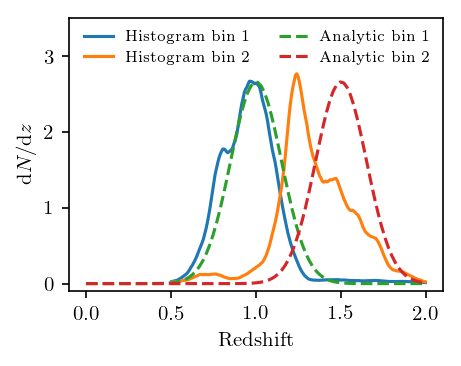

In [4]:
z = np.linspace(0, 2, 100)
# Bin 1: Gaussian with sigma = 0.15, centered at z_1 = 1.0
bin_analytic1 = np.exp(-0.5*(z-1.0)**2/0.15**2)
bin_analytic1 /= np.trapz(bin_analytic1, z)
# Bin 2: Gaussian with sigma =0.15 and centered at z_2 = 1.5
bin_analytic2 = np.exp(-0.5*(z-1.5)**2/0.15**2)
bin_analytic2 /= np.trapz(bin_analytic2, z)

bin_histo1=np.loadtxt('../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt')
bin_histo2=np.loadtxt('../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt')

plt.figure(figsize=fig_size);
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'${\rm d}N/{\rm d}z$');
plt.xlabel('Redshift');
plt.plot(bin_histo1[:,0],bin_histo1[:,1], c=color_map(0), label="Histogram bin 1")
plt.plot(bin_histo2[:,0],bin_histo2[:,1], c=color_map(1), label="Histogram bin 2")

plt.plot(z, bin_analytic1, ls="--", c=color_map(2), label="Analytic bin 1")
plt.plot(z, bin_analytic2, ls="--", c=color_map(3), label="Analytic bin 2")

plt.ylim(-0.1, 3.5)

plt.legend(frameon=False, fontsize="x-small", ncol=2)

plt.savefig('dNdz_codecomp.pdf');
plt.show();
plt.clf();

## Background functions

### Cosmological Distances

With the cosmologies set up, we will not compute comoving radial distances and compare them to our input benchmark files. First, let's load the benchmark file. The format is: (z,d1,d2,d3,d4,d5) where z is the redshift, d are distances and 1-5 refers to the cosmologies set up above. The units are Mpc/h.

In [5]:
bench=np.loadtxt('../tests/benchmark/chi_model1-5.txt')
z=bench[1:,0]
d_bench=bench[1:,1:]
scale_fact=1./(1+z)

Now let's calculate CCL predictions to compare against the benchmark. Notice CCL returns quantities in units of Mpc.

In [6]:
def compute_ccl_bench_bg(cosmos,a_list,func,h_power=0) :
    o_ccl=np.transpose(np.array([func(c,a_list)*pow(c['h'],h_power) for c in cosmos]))
    return o_ccl
d_ccl=compute_ccl_bench_bg(cosmo_list[:num_models],scale_fact,ccl.comoving_radial_distance,1.)

And we will now make a plot comparing the two quantities.

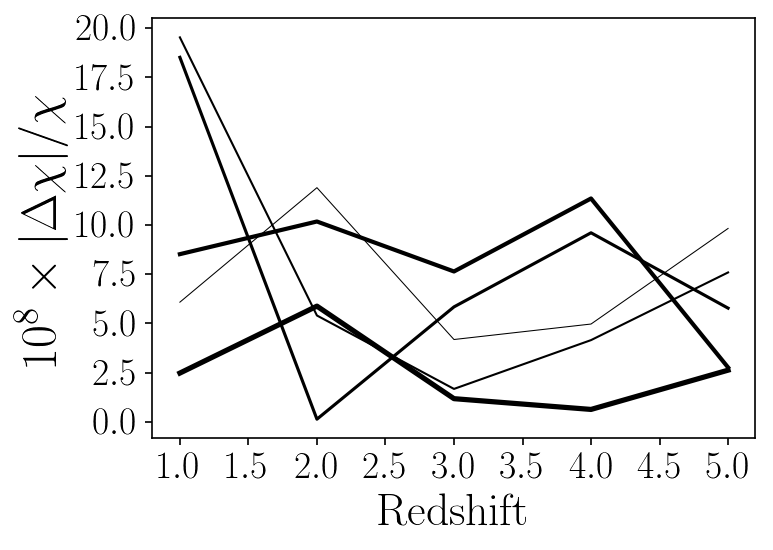

In [7]:
def plot_ccl_bench_bg(f_bench,f_ccl,z_list,title,tol,figname) :
    plt.figure();
    plt.gcf().subplots_adjust(left=0.23)
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel(title,fontsize=24);
    plt.xlabel('Redshift',fontsize=22);
    plt.xticks(fontsize=18);
    plt.yticks(fontsize=18);
    for i in range(len(f_bench[0])):
        plt.plot(z_list,np.abs(f_bench[:,i]/f_ccl[:,i]-1)/tol,'k-',lw=i*0.5+0.5);
    plt.savefig(figname+'.pdf');
    plt.show();
    plt.clf();
plot_ccl_bench_bg(d_bench,d_ccl,z,r'$10^8\times|\Delta\chi|/\chi$',1E-8,'distances');

### Cosmological distances with massive neutrinos
The above checks distances for cosmologies only without massive neutrinos. We also want to check the distance functionality in cosmologies with massive neutrinos. We use cosmologies very similar to 1-5 above, the only difference being the neutrino parameters and that we don't force Omega_g to 0. Note we set Neff to 3 because we compare to benchmarks calculated using astropy which splits passed neutrinos masses equally amongst the Neff neutrinos.

In [8]:
cosmo_cclmnu1 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, 
    Neff=3, m_nu=[0.04, 0., 0.])

cosmo_cclmnu2 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, w0=-0.9, 
    Neff=3, m_nu=[0.05, 0.01, 0.])

cosmo_cclmnu3  =ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, n_s=0.96, 
    w0=-0.9, wa=0.1, Neff=3, m_nu=[0.03, 0.02, 0.04])

cosmo_cclmnu4 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, Omega_k=0.05, h=0.7, A_s = 2.1e-9, 
    n_s=0.96, w0=-0.9, wa=0.1, Neff=3, m_nu=[0.05, 0., 0.])

cosmo_cclmnu5 = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, Omega_k=-0.05, h=0.7, A_s = 2.1e-9, 
    n_s=0.96, w0=-0.9, wa=0.1, Neff=3, m_nu=[0.03, 0.02, 0.])

cosmo_mnu_list= [
    cosmo_cclmnu1, cosmo_cclmnu2, 
    cosmo_cclmnu3, cosmo_cclmnu4, cosmo_cclmnu5]

num_models_mnu = 5

We load the benchmark file, which has the same format as above.

In [9]:
bench=np.loadtxt('../tests/benchmark/chi_mnu_model1-5.txt')
z_mnu =bench[:,0]
d_bench_mnu =bench[:,1:]
scale_fact_mnu =1./(1+z)

Calculate the distances for cosmologies with massive neutrinos.

In [10]:
d_mnu_ccl=compute_ccl_bench_bg(cosmo_mnu_list[:num_models_mnu],scale_fact_mnu,ccl.comoving_radial_distance)

Plot the discrepancy between benchmarks and ccl. Note that in this case we have a tolerance of $10^{-3}$, because we compare with benchmarks produced by astropy, which uses a fitting formula for the neutrino phasespace integral, which itself differs from the exact expression at greater than a $10^{-4}$ level. 

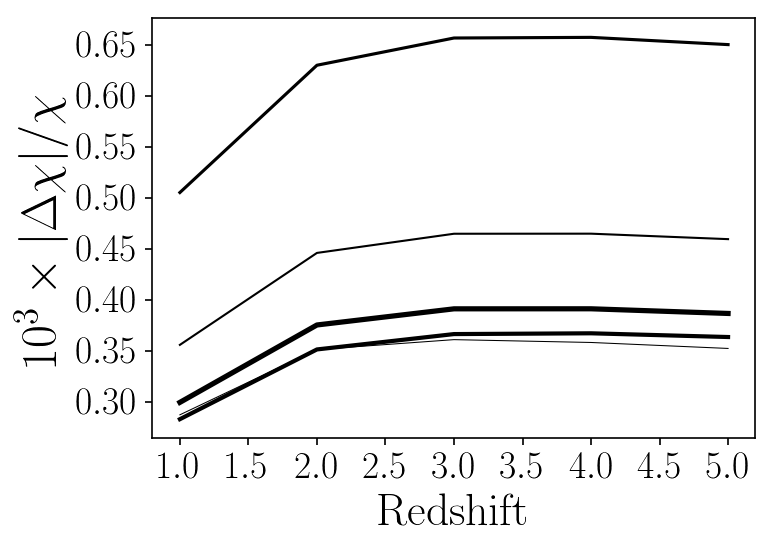

In [11]:
plot_ccl_bench_bg(d_bench_mnu,d_mnu_ccl,z_mnu,r'$10^3\times|\Delta\chi|/\chi$',1E-3,'distances_nu');

### Cosmological distances (high z)

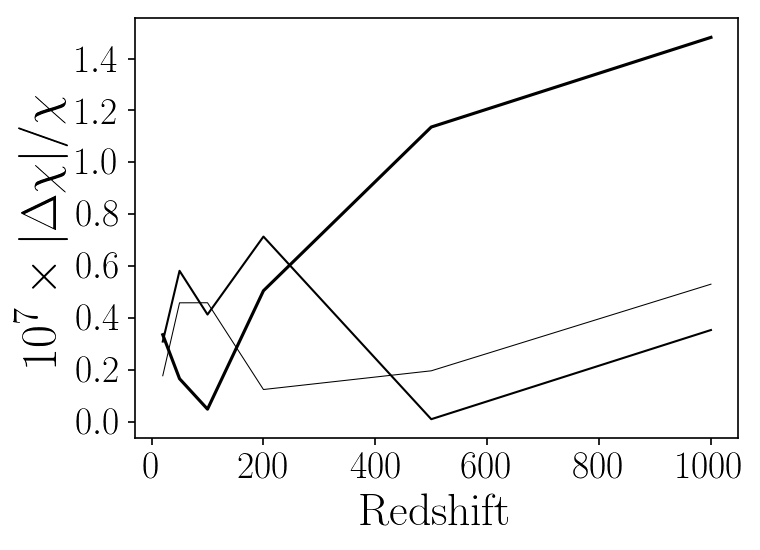

In [12]:
bench=np.loadtxt('../tests/benchmark/chi_hiz_model1-3.txt')
z=bench[1:,0]
d_hiz_bench=bench[1:,1:]
scale_fact=1./(1+z)
d_hiz_ccl=compute_ccl_bench_bg(cosmo_list[:num_models_hiz],scale_fact,ccl.comoving_radial_distance,1.)
plot_ccl_bench_bg(d_hiz_bench,d_hiz_ccl,z,r'$10^7\times|\Delta\chi|/\chi$',1E-7,'distances_hiz')

### Cosmological distances (high z, with massive neutrinos)
Similarly to above, we only require $10^{-3}$ accuracy here because we compare to benchmarks from astropy, which uses a fitting function for the phase space neutrino integral which itself differs from the exact value at greater than the $10^{-4}$ level.

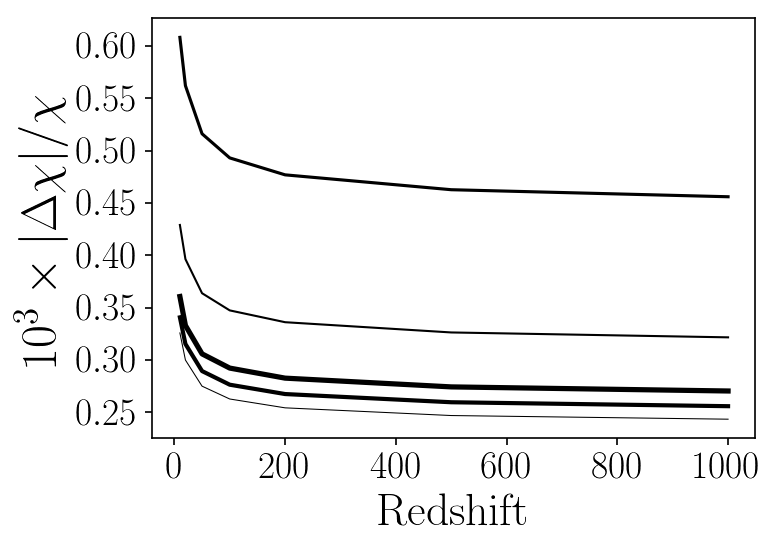

In [13]:
bench=np.loadtxt('../tests/benchmark/chi_hiz_mnu_model1-5.txt')
z_mnu=bench[:,0]
d_hiz_mnu_bench=bench[:,1:]
scale_fact_mnu=1./(1+z_mnu)
d_hiz_mnu_ccl=compute_ccl_bench_bg(cosmo_mnu_list[:num_models_mnu],scale_fact_mnu,ccl.comoving_radial_distance,0.)
plot_ccl_bench_bg(d_hiz_mnu_bench,d_hiz_mnu_ccl,z_mnu,r'$10^3\times|\Delta\chi|/\chi$',1E-3,'distances_nu_hiz')

### Growth function (low z)

We now show the accuracy attained in predicting the growth function. In this case, we only work with cosmologies without massive neutrinos. This is due to the growth function becoming scale-dependent in the presence of massive neutrinos, in which case the full matter power spectrum should be used. Separate checks of the matter power spectrum are in place below.

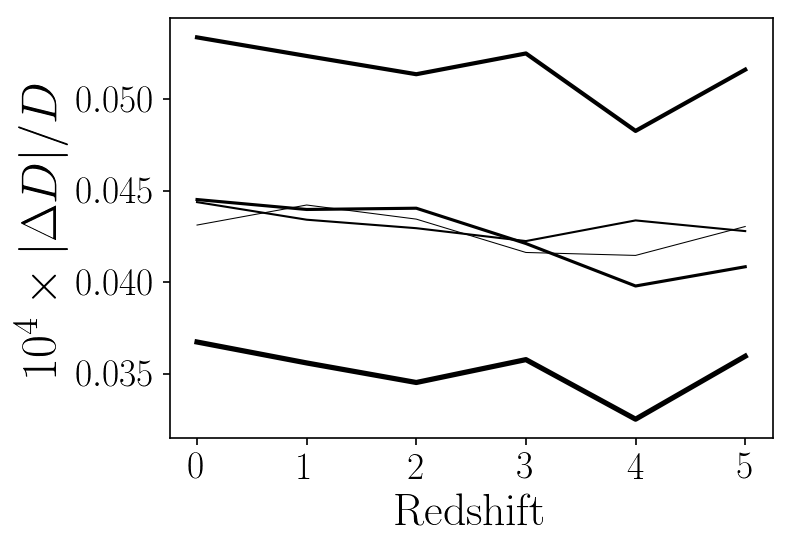

In [14]:
bench=np.loadtxt('../tests/benchmark/growth_model1-5.txt')
z=bench[:,0]
g_bench=bench[0:,1:]
scale_fact=1./(1+z)
g_ccl=compute_ccl_bench_bg(cosmo_list[:num_models],scale_fact,ccl.growth_factor_unnorm,0.)
plot_ccl_bench_bg(g_bench,g_ccl,z,r'$10^4\times|\Delta D|/D$',1E-4,'growth')

### Growth function (high z)

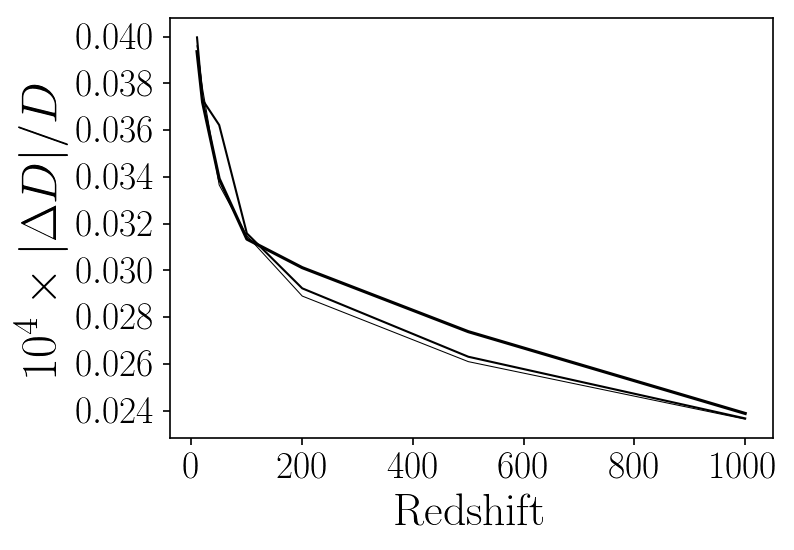

In [15]:
bench=np.loadtxt('../tests/benchmark/growth_hiz_model1-3.txt')
z=bench[0:,0]
num_z = np.shape(bench)[0]
g_hiz_bench=bench[0:,1:]
scale_fact=1./(1+z)
bench=np.loadtxt('../tests/benchmark/growth_model1-5.txt')
g_hiz_ccl=compute_ccl_bench_bg(cosmo_list[:num_models_hiz],scale_fact,ccl.growth_factor_unnorm,0.)
plot_ccl_bench_bg(g_hiz_bench,g_hiz_ccl,z,r'$10^4\times|\Delta D|/D$',1E-4,'growth_hiz')

## Consolidated background benchmark plots

This additional set of benchmarks and plots studies the accuracy of distances and growth in comparison to CLASS and CosmoMAD outputs. These tests are also implemented as part of the C automated tests.

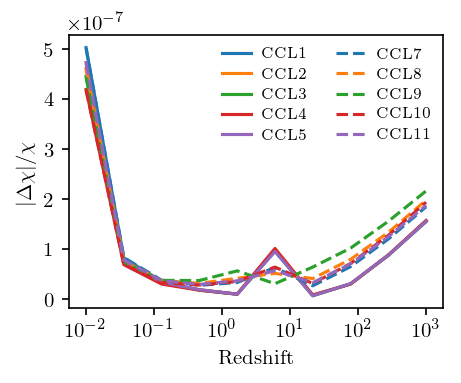

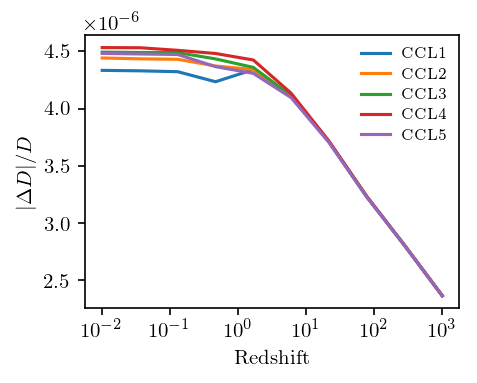

In [16]:
def plot_ccl_bench_bg_new(f_bench, f_ccl, z_list, title, figname, labels):
    plt.figure(figsize=fig_size)
    plt.gcf().subplots_adjust(**plot_adjust)
    plt.ylabel(title)
    plt.xlabel('Redshift')
    if isinstance(f_bench, list):
        # Inlcude massive neutrinos on the same plot
        for i in range(len(f_bench[0][0])):
            plt.plot(z_list, np.abs(f_bench[0][:,i]/f_ccl[0][:,i]-1), 
                     ls='-', c=color_map(i), label=labels[0][i])
        for i in range(len(f_bench[0][0])):
            plt.plot(z_list, np.abs(f_bench[1][:,i]/f_ccl[1][:,i]-1), 
                     ls='--', c=color_map(i), label=labels[1][i])
        plt.legend(ncol=2, frameon=False, fontsize="x-small")
    else:    
        for i in range(len(f_bench[0])):
            plt.plot(z_list,np.abs(f_bench[:,i]/f_ccl[:,i]-1),
                     ls='-', c=color_map(i), label=labels[i])
        plt.legend(frameon=False, fontsize="x-small")
    plt.xscale("log")
    plt.locator_params(axis="x", numticks=6)
    plt.locator_params(axis="y", nbins=6)
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
#     plt.gca().yaxis.offsetText.set_fontsize(18)
    plt.savefig(figname+'.pdf')
    plt.show()
    plt.clf()
    
def Neff_from_N_ur_N_ncdm(N_ur, N_ncdm):
    """Calculate N_eff from the number of relativistic and massive neutrinos."""
    Neff = N_ur + N_ncdm * ccl.ccllib.TNCDM**4 / (4./11.)**(4./3.)
    return Neff

def compute_distance(z, Omega_k=0.0, Omega_c=0.25, Omega_b=0.05,
                     h=0.7, sigma8=0.8, n_s=0.96,
                     Neff=3.0, m_nu=0.0, w0=-1.0, wa=0.0):
    # Create new Parameters and Cosmology objects
    cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff, 
                       h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k, m_nu=m_nu,
                       w0=w0, wa=wa)    
    
    a = 1. / (1. + z)
    chi = ccl.comoving_radial_distance(cosmo, a)
    return chi

def compute_growth(z, Omega_k=0.0, Omega_c=0.25, Omega_b=0.05,
                   h=0.7, sigma8=0.8, n_s=0.96,
                   Neff=3.0, m_nu=0.0, w0=-1.0, wa=0.0):
    # Create new Parameters and Cosmology objects.
    # The code that is used for the benchmark (CosmoMAD) does not include the radiation terms.
    # For consistency, we set them to zero and reset Omege_l
    cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=0, 
                       h=h, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k, m_nu=m_nu,
                       w0=w0, wa=wa, Omega_g=0)
    
    a = 1. / (1. + z)
    growth = ccl.growth_factor_unnorm(cosmo, a)
    return growth

common_params = dict(Omega_c=0.25, Omega_b=0.05,
                     h=0.7, sigma8=0.8, n_s=0.96)

# The distance benchmark uses CLASS, which requires a non-zero N_eff.
models =      ({"Omega_k"  : 0.0,
                "Neff"     : 3.046},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.0,
                "Neff"     : 3.046},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : 3.046},
               {"Omega_k"  : 0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : 3.046},
               {"Omega_k"  : -0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : 3.046},
              )

mnu_models =  ({"Omega_k"  : 0.0,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=2.0, N_ncdm=1.0),
                "m_nu"     : [0.04, 0.0, 0.0]},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.0,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=1.0, N_ncdm=2.0),
                "m_nu"     : [0.05, 0.01, 0.0]},
               {"Omega_k"  : 0.0,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=0.0, N_ncdm=3.0),
                "m_nu"     : [0.03, 0.02, 0.04]},
               {"Omega_k"  : 0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=2.0, N_ncdm=1.0),
                "m_nu"     : [0.05, 0.0, 0.0]},
               {"Omega_k"  : -0.05,
                "w0"       : -0.9,
                "wa"       : 0.1,
                "Neff"     : Neff_from_N_ur_N_ncdm(N_ur=1.0, N_ncdm=2.0),
                "m_nu"     : [0.03, 0.02, 0.0]},
              )

# benchmark = np.loadtxt("../tests/benchmark/chi_allz_class_CCL1-11.txt")
benchmark = np.loadtxt("../tests/benchmark/chi_class_allz.txt")

z = benchmark[:,0]
chi_benchmark = benchmark[:,1:]

chi_ccl = []
chi_mnu_ccl = []

for m in models:
    params = common_params.copy()
    params.update(m)
    chi_ccl.append(compute_distance(z, **params))
    
for m in mnu_models:
    params = common_params.copy()
    params.update(m)
    chi_mnu_ccl.append(compute_distance(z, **params))

chi_ccl = np.array(chi_ccl).T
chi_mnu_ccl = np.array(chi_mnu_ccl).T

plot_ccl_bench_bg_new([chi_benchmark[:,:5], chi_benchmark[:,5:]], [chi_ccl, chi_mnu_ccl], z, 
                      r'$|\Delta\chi|/\chi$', "distances", 
                      [["CCL1", "CCL2", "CCL3", "CCL4", "CCL5"], ["CCL7", "CCL8", "CCL9", "CCL10", "CCL11"]])

benchmark = np.loadtxt("../tests/benchmark/growth_allz_cosmomad_ccl1-5.txt")
z = benchmark[:,0]
growth_benchmark = benchmark[:,1:]

growth_ccl = []

for m in models:
    growth_ccl.append(compute_growth(z, **m))
    
growth_ccl = np.array(growth_ccl).T

plot_ccl_bench_bg_new(growth_benchmark, growth_ccl, z, r'$|\Delta D|/D$', "growth", 
                      ["CCL1", "CCL2", "CCL3", "CCL4", "CCL5"])


## Angular power spectra

In what follows, we test the accuracy of the angular power spectra predicted by CCL. Once more, we compare CCL runs to predictions made by independent codes. We take two different approaches to the redshift distribution: a binned and an analytic one. We make predictions for clustering, lensing and CMB lensing.

In [17]:
accuracy = 1e-3

#Redshift distribution
zmean1=1.0; zmean2=1.5;
sigz1=0.15; sigz2=0.15;
nzs=512;

#Analytic redshift distributions
z_a_1=np.linspace(zmean1-5*sigz1,zmean1+5*sigz1,nzs);
z_a_2=np.linspace(zmean2-5*sigz2,zmean2+5*sigz2,nzs);
pz_a_1=np.exp(-0.5*((z_a_1-zmean1)/sigz1)**2)
pz_a_2=np.exp(-0.5*((z_a_2-zmean2)/sigz2)**2)
#Bias parameters for these distributions
bz_a_1=np.ones_like(z_a_1); bz_a_2=np.ones_like(z_a_2);

#Binned redshift distributions and biases
z_h_1,pz_h_1=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt",unpack=True)[:,1:]
z_h_2,pz_h_2=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt",unpack=True)[:,1:]
bz_h_1=np.ones_like(z_h_1); bz_h_2=np.ones_like(z_h_2);

zarrs={'analytic':{'b1':{'z':z_a_1,'nz':pz_a_1,'bz':bz_a_1},'b2':{'z':z_a_2,'nz':pz_a_2,'bz':bz_a_2}},
      'histo':{'b1':{'z':z_h_1,'nz':pz_h_1,'bz':bz_h_1},'b2':{'z':z_h_2,'nz':pz_h_2,'bz':bz_h_2}}}

#Initialize tracers
cosmo_cls=cosmo_list[-2]
cosmo_cls_cmbl=cosmo_list[-1]
trcrs={}
for nztyp in ['analytic','histo'] :
    trcrs[nztyp]={}
    za=zarrs[nztyp]
    trcrs[nztyp]['nc_1']=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,
                                                dndz=(za['b1']['z'],za['b1']['nz']),
                                                bias=(za['b1']['z'],za['b1']['bz']))
    trcrs[nztyp]['nc_2']=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,
                                                dndz=(za['b2']['z'],za['b2']['nz']),
                                                bias=(za['b2']['z'],za['b2']['bz']))
    trcrs[nztyp]['wl_1']=ccl.WeakLensingTracer(cosmo_cls,
                                               dndz=(za['b1']['z'],za['b1']['nz']))
    trcrs[nztyp]['wl_2']=ccl.WeakLensingTracer(cosmo_cls,
                                               dndz=(za['b2']['z'],za['b2']['nz']))
    trcrs[nztyp]['cmbl']=ccl.CMBLensingTracer(cosmo_cls,1100.)
    trcrs[nztyp]['cmblb']=ccl.CMBLensingTracer(cosmo_cls_cmbl,1100.)

cl_bench={}
for nztyp in ['analytic','histo'] :
    cl_bench[nztyp]={}
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b1"+nztyp+"_log_cl_dd.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_1/nc_1']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b2"+nztyp+"_log_cl_dd.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_1/nc_2']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b1"+nztyp+"_log_cl_dl.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_1/wl_1']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b2"+nztyp+"_log_cl_dl.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_1/wl_2']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b1"+nztyp+"_log_cl_dc.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_1/cmbl']=cl
    
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b2b2"+nztyp+"_log_cl_dd.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_2/nc_2']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b2b2"+nztyp+"_log_cl_dl.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_2/wl_2']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b2b2"+nztyp+"_log_cl_dc.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['nc_2/cmbl']=cl

    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b1"+nztyp+"_log_cl_ll.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['wl_1/wl_1']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b2"+nztyp+"_log_cl_ll.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['wl_1/wl_2']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b1b1"+nztyp+"_log_cl_lc.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['wl_1/cmbl']=cl

    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b2b2"+nztyp+"_log_cl_ll.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['wl_2/wl_2']=cl
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_b2b2"+nztyp+"_log_cl_lc.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['wl_2/cmbl']=cl
    
    l,cl=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/run_log_cl_cc.txt",unpack=True)[:,:3001]
    cl_bench[nztyp]['cmbl/cmbl']=cl

cl_ccl={}
el_ccl={}
ells=np.loadtxt("larr_cls.txt").astype(int)
for nztyp in ['analytic','histo'] :
    #Limber prefactors
    lf_dl=(ells+0.5)**2/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))
    lf_dc=(ells+0.5)**2/(ells*(ells+1.))
    lf_ll=ells*(ells+1.)/np.sqrt((ells+2.)*(ells+1.)*ells*(ells-1.))
    
    #Power spectra
    cl_ccl[nztyp]={}
    cl_ccl[nztyp]['nc_1/nc_1']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_1'],trcrs[nztyp]['nc_1'],ells)
    cl_ccl[nztyp]['nc_1/nc_2']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_1'],trcrs[nztyp]['nc_2'],ells)
    cl_ccl[nztyp]['nc_1/wl_1']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_1'],trcrs[nztyp]['wl_1'],ells)*lf_dl
    cl_ccl[nztyp]['nc_1/wl_2']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_1'],trcrs[nztyp]['wl_2'],ells)*lf_dl
    cl_ccl[nztyp]['nc_1/cmbl']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_1'],trcrs[nztyp]['cmbl'],ells)*lf_dc
    cl_ccl[nztyp]['nc_2/nc_2']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_2'],trcrs[nztyp]['nc_2'],ells)
    cl_ccl[nztyp]['nc_2/wl_2']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_2'],trcrs[nztyp]['wl_2'],ells)*lf_dl
    cl_ccl[nztyp]['nc_2/cmbl']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['nc_2'],trcrs[nztyp]['cmbl'],ells)*lf_dc
    cl_ccl[nztyp]['wl_1/wl_1']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['wl_1'],trcrs[nztyp]['wl_1'],ells)*lf_ll**2
    cl_ccl[nztyp]['wl_1/wl_2']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['wl_1'],trcrs[nztyp]['wl_2'],ells)*lf_ll**2
    cl_ccl[nztyp]['wl_1/cmbl']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['wl_1'],trcrs[nztyp]['cmbl'],ells)*lf_ll
    cl_ccl[nztyp]['wl_2/wl_2']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['wl_2'],trcrs[nztyp]['wl_2'],ells)*lf_ll**2
    cl_ccl[nztyp]['wl_2/cmbl']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['wl_2'],trcrs[nztyp]['cmbl'],ells)*lf_ll
    cl_ccl[nztyp]['cmbl/cmbl']=ccl.angular_cl(cosmo_cls,
                                       trcrs[nztyp]['cmblb'],trcrs[nztyp]['cmblb'],ells)
    
    #Cosmic variance errors
    el_ccl[nztyp]={}
    el_ccl[nztyp]['nc_1/nc_1']=np.sqrt((cl_ccl[nztyp]['nc_1/nc_1']*cl_ccl[nztyp]['nc_1/nc_1']+
                                        cl_ccl[nztyp]['nc_1/nc_1']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_1/nc_2']=np.sqrt((cl_ccl[nztyp]['nc_1/nc_1']*cl_ccl[nztyp]['nc_2/nc_2']+
                                        cl_ccl[nztyp]['nc_1/nc_2']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_1/wl_1']=np.sqrt((cl_ccl[nztyp]['nc_1/nc_1']*cl_ccl[nztyp]['wl_1/wl_1']+
                                        cl_ccl[nztyp]['nc_1/wl_1']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_1/wl_2']=np.sqrt((cl_ccl[nztyp]['nc_1/nc_1']*cl_ccl[nztyp]['wl_2/wl_2']+
                                        cl_ccl[nztyp]['nc_1/wl_2']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_1/cmbl']=np.sqrt((cl_ccl[nztyp]['nc_1/nc_1']*cl_ccl[nztyp]['cmbl/cmbl']+
                                        cl_ccl[nztyp]['nc_1/cmbl']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_2/nc_2']=np.sqrt((cl_ccl[nztyp]['nc_2/nc_2']*cl_ccl[nztyp]['nc_2/nc_2']+
                                        cl_ccl[nztyp]['nc_2/nc_2']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_2/wl_2']=np.sqrt((cl_ccl[nztyp]['nc_2/nc_2']*cl_ccl[nztyp]['wl_2/wl_2']+
                                        cl_ccl[nztyp]['nc_2/wl_2']**2)/(2*ells+1.))
    el_ccl[nztyp]['nc_2/cmbl']=np.sqrt((cl_ccl[nztyp]['nc_2/nc_2']*cl_ccl[nztyp]['cmbl/cmbl']+
                                        cl_ccl[nztyp]['nc_2/cmbl']**2)/(2*ells+1.))
    el_ccl[nztyp]['wl_1/wl_1']=np.sqrt((cl_ccl[nztyp]['wl_1/wl_1']*cl_ccl[nztyp]['wl_1/wl_1']+
                                        cl_ccl[nztyp]['wl_1/wl_1']**2)/(2*ells+1.))
    el_ccl[nztyp]['wl_1/wl_2']=np.sqrt((cl_ccl[nztyp]['wl_1/wl_1']*cl_ccl[nztyp]['wl_2/wl_2']+
                                        cl_ccl[nztyp]['wl_1/wl_2']**2)/(2*ells+1.))
    el_ccl[nztyp]['wl_1/cmbl']=np.sqrt((cl_ccl[nztyp]['wl_1/wl_1']*cl_ccl[nztyp]['cmbl/cmbl']+
                                        cl_ccl[nztyp]['wl_1/cmbl']**2)/(2*ells+1.))
    el_ccl[nztyp]['wl_2/wl_2']=np.sqrt((cl_ccl[nztyp]['wl_2/wl_2']*cl_ccl[nztyp]['wl_2/wl_2']+
                                        cl_ccl[nztyp]['wl_2/wl_2']**2)/(2*ells+1.))
    el_ccl[nztyp]['wl_2/cmbl']=np.sqrt((cl_ccl[nztyp]['wl_2/wl_2']*cl_ccl[nztyp]['cmbl/cmbl']+
                                        cl_ccl[nztyp]['wl_2/cmbl']**2)/(2*ells+1.))
    el_ccl[nztyp]['cmbl/cmbl']=np.sqrt((cl_ccl[nztyp]['cmbl/cmbl']*cl_ccl[nztyp]['cmbl/cmbl']+
                                        cl_ccl[nztyp]['cmbl/cmbl']**2)/(2*ells+1.))

#And make a figure that compares the results, plotting the fractional relative difference
#between benchmark angular spectra and CCL output. We make each figure in a separate block below
ltypes={'analytic':'-','histo':'--'}


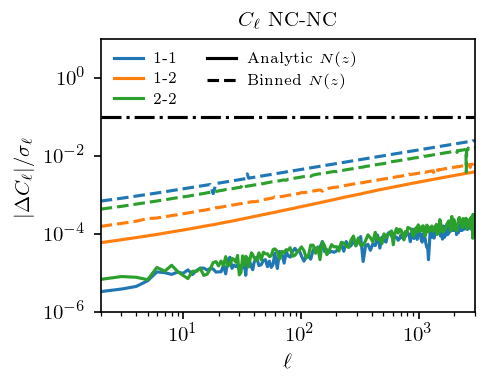

In [18]:

#Galaxy-Galaxy
title=r' $C_\ell$ NC-NC'
plt.figure(figsize=fig_size)
plt.title(title)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta C_\ell|/\sigma_\ell$')
plt.xlabel(r'$\ell$')
for itag,tag in enumerate(['nc_1/nc_1','nc_1/nc_2','nc_2/nc_2']) :
    for nztyp in ['analytic','histo'] :
        plt.plot(ells,np.fabs(cl_bench[nztyp][tag][ells]-cl_ccl[nztyp][tag])/el_ccl[nztyp][tag],
                 ls=ltypes[nztyp],c=color_map(itag))
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(0),label='1-1')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(1),label='1-2')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(2),label='2-2')
plt.plot([-1,-1],[-1,-1],ls='-',c='k',label='Analytic $N(z)$')
plt.plot([-1,-1],[-1,-1],ls='--',c='k',label='Binned $N(z)$')
plt.axhline(0.1, c="k", ls="-.")
plt.xscale('log');
plt.yscale('log');
plt.ylim([1e-6, 10])
plt.xlim([2,2980])
plt.legend(loc='upper left',ncol=2, frameon=False, fontsize="x-small");
plt.savefig('Cl_dd.pdf')
plt.show();
plt.clf();


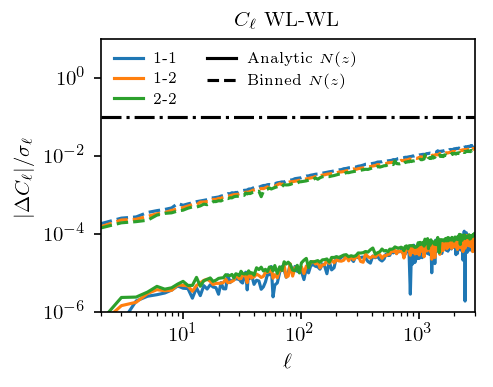

In [19]:
#Shear-Shear
title=r' $C_\ell$ WL-WL'
plt.figure(figsize=fig_size)
plt.title(title)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta C_\ell|/\sigma_\ell$')
plt.xlabel(r'$\ell$')
for itag,tag in enumerate(['wl_1/wl_1','wl_1/wl_2','wl_2/wl_2']) :
    for nztyp in ['analytic','histo'] :
        plt.plot(ells,np.fabs(cl_bench[nztyp][tag][ells]-cl_ccl[nztyp][tag])/el_ccl[nztyp][tag],
                 ls=ltypes[nztyp],c=color_map(itag))
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(0),label='1-1')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(1),label='1-2')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(2),label='2-2')
plt.plot([-1,-1],[-1,-1],ls='-',c='k',label='Analytic $N(z)$')
plt.plot([-1,-1],[-1,-1],ls='--',c='k',label='Binned $N(z)$')
plt.axhline(0.1, c="k", ls="-.")
plt.xscale('log');
plt.yscale('log');
plt.ylim([1e-6, 10])
plt.xlim([2,2980])
plt.legend(loc='upper left',ncol=2, frameon=False, fontsize="x-small");
plt.savefig('Cl_ll.pdf')
plt.show();
plt.clf();


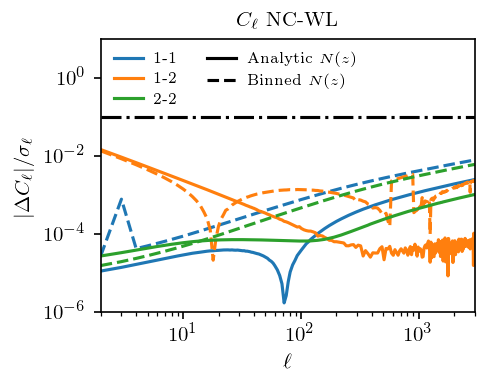

In [20]:
#galaxy-shear
title=r' $C_\ell$ NC-WL'
plt.figure(figsize=fig_size)
plt.title(title)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta C_\ell|/\sigma_\ell$')
plt.xlabel(r'$\ell$')
for itag,tag in enumerate(['nc_1/wl_1','nc_1/wl_2','nc_2/wl_2']) :
    for nztyp in ['analytic','histo'] :
        plt.plot(ells,np.fabs(cl_bench[nztyp][tag][ells]-cl_ccl[nztyp][tag])/el_ccl[nztyp][tag],
                 ls=ltypes[nztyp],c=color_map(itag))
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(0),label='1-1')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(1),label='1-2')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(2),label='2-2')
plt.plot([-1,-1],[-1,-1],ls='-',c='k',label='Analytic $N(z)$')
plt.plot([-1,-1],[-1,-1],ls='--',c='k',label='Binned $N(z)$')
plt.axhline(0.1, c="k", ls="-.")
plt.xscale('log');
plt.yscale('log');
plt.ylim([1e-6, 10])
plt.xlim([2,2980])
plt.legend(loc='upper left',ncol=2, frameon=False, fontsize="x-small");
plt.savefig('Cl_dl.pdf')
plt.show();
plt.clf();


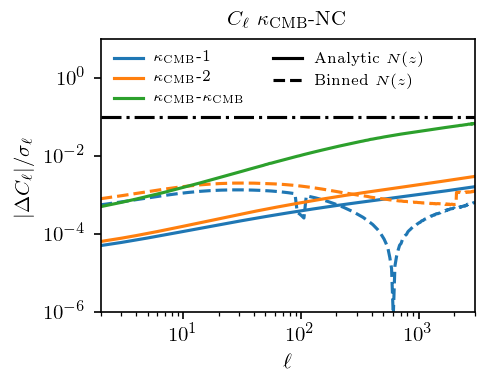

In [21]:
#galaxy-CMBl
title=r' $C_\ell$ $\kappa_{\rm CMB}$-NC'
plt.figure(figsize=fig_size)
plt.title(title)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta C_\ell|/\sigma_\ell$')
plt.xlabel(r'$\ell$')
for itag,tag in enumerate(['nc_1/cmbl','nc_2/cmbl']) :
    for nztyp in ['analytic','histo'] :
        plt.plot(ells,np.fabs(cl_bench[nztyp][tag][ells]-cl_ccl[nztyp][tag])/el_ccl[nztyp][tag],
                 ls=ltypes[nztyp],c=color_map(itag))
for itag,tag in enumerate(['cmbl/cmbl']) :
    for nztyp in ['analytic'] :
        plt.plot(ells,np.fabs(cl_bench[nztyp][tag][ells]-cl_ccl[nztyp][tag])/el_ccl[nztyp][tag],
                 ls=ltypes[nztyp],c=color_map(2))
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(0),label='$\\kappa_{\\rm CMB}$-1')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(1),label='$\\kappa_{\\rm CMB}$-2')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(2),label='$\\kappa_{\\rm CMB}$-$\\kappa_{\\rm CMB}$')
plt.plot([-1,-1],[-1,-1],ls='-',c='k',label='Analytic $N(z)$')
plt.plot([-1,-1],[-1,-1],ls='--',c='k',label='Binned $N(z)$')
plt.axhline(0.1, c="k", ls="-.")
plt.xscale('log');
plt.yscale('log');
plt.ylim([1e-6, 10])
plt.xlim([2,2980])
plt.legend(loc='upper left',ncol=2, frameon=False, fontsize="x-small");
plt.savefig('Cl_dc.pdf')
plt.show();
plt.clf();


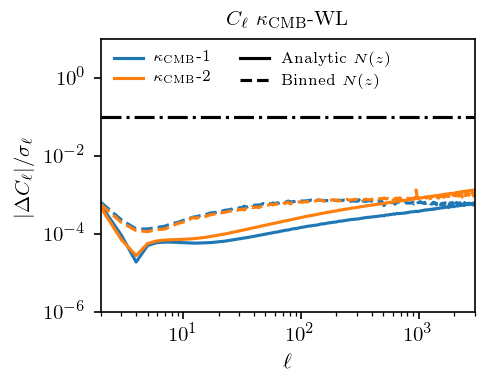

In [22]:
#shear-CMBl
title=r' $C_\ell$ $\kappa_{\rm CMB}$-WL'
plt.figure(figsize=fig_size)
plt.title(title)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta C_\ell|/\sigma_\ell$')
plt.xlabel(r'$\ell$')
for itag,tag in enumerate(['wl_1/cmbl','wl_2/cmbl']) :
    for nztyp in ['analytic','histo'] :
        plt.plot(ells,np.fabs(cl_bench[nztyp][tag][ells]-cl_ccl[nztyp][tag])/el_ccl[nztyp][tag],
                 ls=ltypes[nztyp],c=color_map(itag))
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(0),label='$\\kappa_{\\rm CMB}$-1')
plt.plot([-1,-1],[-1,-1],ls='-',c=color_map(1),label='$\\kappa_{\\rm CMB}$-2')
plt.plot([-1,-1],[-1,-1],ls='-',c='k',label='Analytic $N(z)$')
plt.plot([-1,-1],[-1,-1],ls='--',c='k',label='Binned $N(z)$')
plt.axhline(0.1, c="k", ls="-.")
plt.xscale('log');
plt.yscale('log');
plt.ylim([1e-6, 10])
plt.xlim([2,2980])
plt.legend(loc='upper left',ncol=2, frameon=False, fontsize="x-small");
plt.savefig('Cl_lc.pdf')
plt.show();
plt.clf();


## Non limber (Angpow)

The CCL non-Limber outputs can be sped up by calling the Angpow code. Here we test the Angpow prediction against CCL to ensure there is good accuracy in the angular power spectra predicted with Angpow. Notice this test will only work with a specific tagged version of CCL.

In [23]:
cosmo=ccl.Cosmology(Omega_c=0.25,Omega_b=0.05,h=0.7,A_s = 2.1e-9,n_s=0.96,Omega_g=0,matter_power_spectrum='linear')

#Redshift distribution
zmean=1.0
sigz=0.02
nzs=1024

#dN/dz and bias
z_a=np.linspace(zmean-5*sigz,zmean+5*sigz,nzs);
pz_a=np.exp(-0.5*((z_a-zmean)/sigz)**2)
bz_a=np.ones_like(z_a)

# set tracer
nc = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z_a,pz_a), bias=(z_a,bz_a))

In [24]:
#This is the CCL non-Limber computation
ell_arr,native_cls = np.loadtxt("../tests/benchmark/angpow_gg.txt",unpack=True);
#This is the CCL Limber computation 
limber_cls = ccl.angular_cl(cosmo, nc, nc, ell_arr)

In [25]:
#This is the CCL non-Limber computation via Angpow)
angpow_cls = ccl.angular_cl(cosmo, nc, nc, ell_arr, l_limber=500,l_linstep=40, l_logstep=1.15)

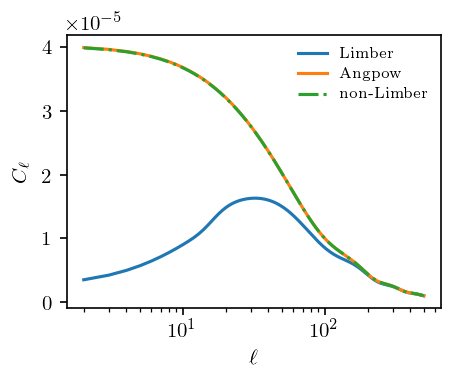

In [26]:
#This figure shows all three computations
plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$')
plt.plot(ell_arr,limber_cls, ls='-', color=color_map(0) ,label='Limber')
plt.plot(ell_arr,angpow_cls, ls='-', color=color_map(1),label='Angpow')
plt.plot(ell_arr,native_cls, ls='-.', color=color_map(2),label='non-Limber')
plt.xscale('log')
plt.legend(loc='upper right',frameon=False, fontsize="x-small")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.savefig('angpow1.pdf')
plt.show();
plt.clf();

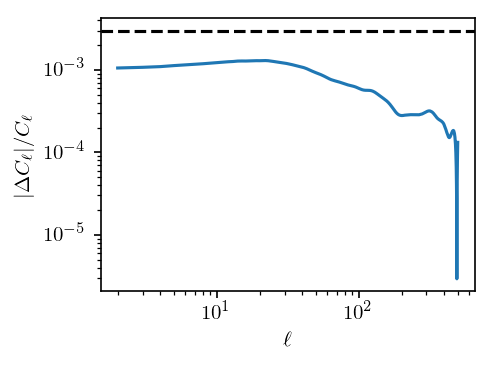

In [27]:
#We now compare the angpow result to the slow CCL prediction of the non-Limber power spectra
#in terms of their absolute fractional difference.
accuracy = 3e-3

plt.figure(figsize=fig_size);
plt.gcf().subplots_adjust(**plot_adjust)
# plt.title('Comparison between methods');
plt.ylabel(r'$|\Delta C_\ell|/C_\ell$')
plt.xlabel(r'$\ell$')
#plt.plot(ell_arr,200*np.abs(angpow_cls/native_cls-1)/np.sqrt(2./(2*ell_arr+1)),'r-',label='method ratio over cosmic variance');
plt.plot(ell_arr,np.abs(angpow_cls/native_cls-1), c=color_map(0));
plt.axhline(accuracy, c="k", ls="--")
plt.xscale('log');
plt.yscale('log');
# plt.ylim([0,1.18])
#plt.legend(loc='upper right',prop={'size':12},frameon=False);
plt.savefig('angpow3.pdf');
plt.show();
plt.clf();

## Projected correlation function

The following section describes the accuracy attained in the predictions of the projected correlation function. Similarly to the case of the angular power spectra, we have benchmarks for analytic and binned redshift distributions. The correlation function benchmarks use the same cosmological parameters and matter power spectra to begin with, but all intermediate calculations (including angular power spectra) are different. In this case, we are establishing the accuracy in comparison to the size of the expected LSST error bars.

In [67]:
#Read benchmarks and expected LSST error bars
bench_err={}
bench_err['dd']=np.genfromtxt("../tests/benchmark/cov_corr/sigma_clustering_Nbin5",names=('theta','b1b1','b2b2','b1b2'))
bench_err['ll+']=np.genfromtxt("../tests/benchmark/cov_corr/sigma_xi+_Nbin5",names=('theta','b1b1','b2b2','b1b2'))
bench_err['ll-']=np.genfromtxt("../tests/benchmark/cov_corr/sigma_xi-_Nbin5",names=('theta','b1b1','b2b2','b1b2'))

corr_bench={}
for nztyp in ['analytic','histo'] :
    corr_bench[nztyp]={}
    for bn in ['b1b1','b2b2'] :
        corr_bench[nztyp][bn]={}
        for trtyp in ['dd','ll'] :
            if  'dd' in trtyp:
                corr_bench[nztyp][bn][trtyp]=np.genfromtxt("../tests/benchmark/codecomp_step2_outputs/run_"+bn+nztyp+"_log_wt_"+trtyp+".txt",names=('theta','xi'))
            else:
                corr_bench[nztyp][bn][trtyp+'+']=np.genfromtxt("../tests/benchmark/codecomp_step2_outputs/run_"+bn+nztyp+"_log_wt_"+trtyp+"_pp.txt",names=('theta','xi'))
                corr_bench[nztyp][bn][trtyp+'-']=np.genfromtxt("../tests/benchmark/codecomp_step2_outputs/run_"+bn+nztyp+"_log_wt_"+trtyp+"_mm.txt",names=('theta','xi'))
                
theta_deg=corr_bench[nztyp][bn]['dd']['theta']

In [68]:
#Get Cls to compute correlation
#Redshift distribution
zmean1=1.0; zmean2=1.5;
sigz1=0.15; sigz2=0.15;
nzs=512;

#Analytic redshift distributions
z_a_1=np.linspace(zmean1-5*sigz1,zmean1+5*sigz1,nzs);
z_a_2=np.linspace(zmean2-5*sigz2,zmean2+5*sigz2,nzs);
pz_a_1=np.exp(-0.5*((z_a_1-zmean1)/sigz1)**2)
pz_a_2=np.exp(-0.5*((z_a_2-zmean2)/sigz2)**2)
#Bias parameters for these distributions
bz_a_1=np.ones_like(z_a_1); bz_a_2=np.ones_like(z_a_2);

#Binned redshift distributions and biases
z_h_1,pz_h_1=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt",unpack=True)
z_h_2,pz_h_2=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt",unpack=True)
bz_h_1=np.ones_like(z_h_1); bz_h_2=np.ones_like(z_h_2);

zarrs={'analytic':{'b1':{'z':z_a_1,'nz':pz_a_1,'bz':bz_a_1},'b2':{'z':z_a_2,'nz':pz_a_2,'bz':bz_a_2}},
      'histo':{'b1':{'z':z_h_1,'nz':pz_h_1,'bz':bz_h_1},'b2':{'z':z_h_2,'nz':pz_h_2,'bz':bz_h_2}}}

#Initialize tracers
cosmo_cls=cosmo_list[-2]
cosmo_cls_cmbl=cosmo_list[-1]
trcrs={}
for nztyp in ['analytic','histo'] :
    trcrs[nztyp]={}
    za=zarrs[nztyp]
    for trtyp in ['dd','ll'] :
        trcrs[nztyp][trtyp]={}
        for bn in ['b1','b2'] :
            if trtyp=='dd' :
                trcrs[nztyp][trtyp][bn]=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,
                                                                dndz=(za[bn]['z'],za[bn]['nz']),
                                                                bias=(za[bn]['z'],za[bn]['bz']))
            else :
                trcrs[nztyp][trtyp][bn]=ccl.WeakLensingTracer(cosmo_cls,
                                                            dndz=(za[bn]['z'],za[bn]['nz']))
                
#Compute ccl predictions
cl_ccl={}
for nztyp in ['analytic','histo'] :
    cl_ccl[nztyp]={}
    for trtyp in ['dd','ll'] :
        cl_ccl[nztyp][trtyp]={}
        cl_ccl[nztyp][trtyp]['b1b1']={}
        ells=np.arange(2,10000)
        cfac=np.ones(len(ells))
        if trtyp=='ll' :
            cfac[2:]=ells[2:]*(ells[2:]+1.)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
        cl_ccl[nztyp][trtyp]['b1b1']['ell']=ells
        cl_ccl[nztyp][trtyp]['b1b1']['cell']=ccl.angular_cl(cosmo_cls,trcrs[nztyp][trtyp]['b1'],
                                                            trcrs[nztyp][trtyp]['b1'],ells)*cfac**2
        cl_ccl[nztyp][trtyp]['b1b2']={}
        cfac=np.ones(len(ells))
        if trtyp=='ll' :
            cfac[2:]=ells[2:]*(ells[2:]+1.)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
        cl_ccl[nztyp][trtyp]['b1b2']['ell']=ells
        cl_ccl[nztyp][trtyp]['b1b2']['cell']=ccl.angular_cl(cosmo_cls,trcrs[nztyp][trtyp]['b1'],
                                                            trcrs[nztyp][trtyp]['b2'],ells)*cfac**2
        cl_ccl[nztyp][trtyp]['b2b2']={}
        cfac=np.ones(len(ells))
        if trtyp=='ll' :
            cfac[2:]=ells[2:]*(ells[2:]+1.)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
        cl_ccl[nztyp][trtyp]['b2b2']['ell']=ells
        cl_ccl[nztyp][trtyp]['b2b2']['cell']=ccl.angular_cl(cosmo_cls,trcrs[nztyp][trtyp]['b2'],
                                                            trcrs[nztyp][trtyp]['b2'],ells)*cfac**2

In [69]:
#Assume that c_ell are computed above in the Angular_cl benchmark
#If you haven't run that cell, please scroll up to run it.
#Then proceed to compute the relavent correlation functions: clustering and lensing auto-correlations.
corr={}
for nztyp in ['analytic','histo'] :
    corr[nztyp]={}
    za=zarrs[nztyp]
    for bn in ['b1b1','b2b2'] :
        corr[nztyp][bn]={}
        for trtyp in ['dd','ll'] :
            ell=cl_ccl[nztyp][trtyp][bn]['ell']
            cell=cl_ccl[nztyp][trtyp][bn]['cell']
            if 'dd' in trtyp:
                corr[nztyp][bn][trtyp]=ccl.correlation(cosmo_cls, ell, cell, theta_deg,
                                                       corr_type='GG', method='FFTLog')
            else :
                corr[nztyp][bn][trtyp+'+']=ccl.correlation(cosmo_cls, ell, cell, theta_deg,
                                                       corr_type='L+', method='FFTLog')
                corr[nztyp][bn][trtyp+'-']=ccl.correlation(cosmo_cls, ell, cell, theta_deg,
                                                       corr_type='L-', method='FFTLog')

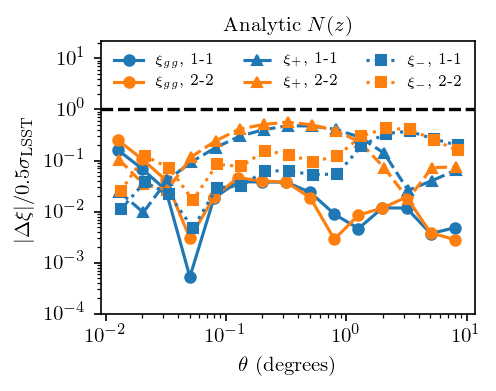

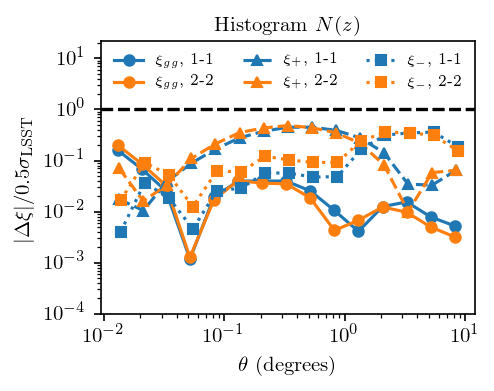

In [70]:
#With the computations done, proceed to compare the difference between benchmark and prediction
#to the size of the LSST error bars.

names={'analytic':'Analytic','histo':'Histogram','dd':r'$\xi_{gg}$','ll+':r'$\xi_+$','ll-':r'$\xi_-$',
       'b1b1':'1-1','b1b2':'1-2','b2b2':'2-2','cb1b1':'r','cb1b2':'b','cb2b2':'y','cdd':'o-','cll+':'^--',
       'cll-':'s:'}

accuracy = 1

inz=0
for nztyp in ['analytic','histo'] :
    plt.figure(figsize=fig_size)

    za=zarrs[nztyp]
    ibn=0
    for trtyp in ['dd','ll+','ll-'] :
        for i, bn in enumerate(['b1b1','b2b2']):
                plt.plot(theta_deg*(1+0.03*(ibn+inz)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']-corr[nztyp][bn][trtyp])/(0.5*bench_err[trtyp][bn]),
                         c=color_map(i), marker=names['c'+trtyp][0], ms=5, ls=names['c'+trtyp][1:], 
                         label=names[trtyp]+', '+names[bn])
                
                plt.xscale('log')
                plt.yscale('log')
        plt.axhline(accuracy, c="k", ls="--")
        plt.legend(ncol=3, fontsize="x-small", frameon=False)
        plt.ylim(1.e-4,22.e0)
        plt.xlabel(r'$\theta$ (degrees)')
        plt.ylabel(r'$|\Delta \xi|/0.5\sigma_{\rm LSST}$')
        ibn+=1
    inz+=1
    plt.title(names[nztyp]+r' $N(z)$')
    plt.gcf().subplots_adjust(**plot_adjust)
    plt.savefig('projected_correlation_error_comparison_'+nztyp+'.pdf')
    plt.show()
    plt.clf()

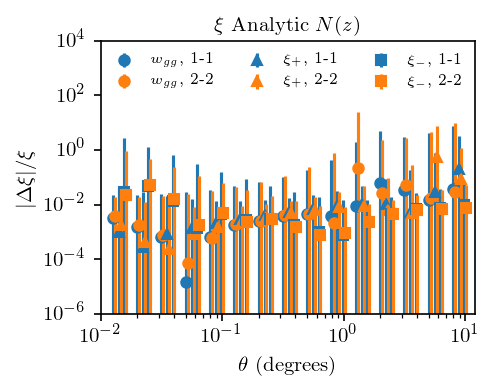

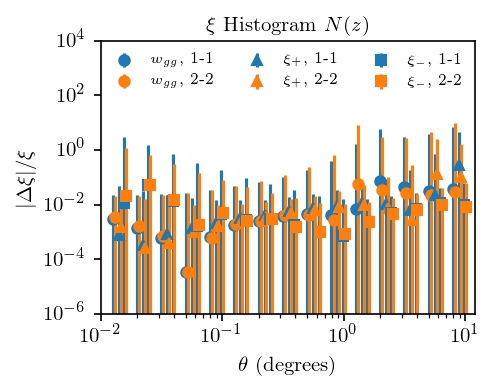

In [71]:
#The following plot shows the relative difference between the CCL prediction and the benchmark. 
#While this plot is informative, the plot that demonstrates the accuracy is the above one.
names={'analytic':'Analytic','histo':'Histogram','dd':r'$w_{gg}$','ll+':r'$\xi_+$','ll-':r'$\xi_-$',
       'b1b1':'1-1','b1b2':'1-2','b2b2':'2-2','cb1b1':'r','cb1b2':'b','cb2b2':'y','cdd':'o','cll+':'^',
       'cll-':'s'}

inz=0
for nztyp in ['analytic','histo'] :
    plt.figure(figsize=fig_size)
    
    za=zarrs[nztyp]
    itr=0
    for trtyp in ['dd','ll+','ll-'] :
        ibn=0
        for i, bn in enumerate(['b1b1','b2b2']):
                plt.errorbar(theta_deg*(1+0.04*(ibn+itr*3)),np.absolute(corr_bench[nztyp][bn][trtyp]['xi']/corr[nztyp][bn][trtyp]-1),
                             0.5*bench_err[trtyp][bn]/corr[nztyp][bn][trtyp]/1,
                             c=color_map(i), ls="none", marker=names['c'+trtyp], ms=5,
                     label=names[trtyp]+', '+names[bn])
                
                plt.xscale('log')
                plt.yscale('log')
                ibn+=1
        plt.ylim(1e-6, 1e4)
        plt.xlim(1.e-2,12)
        plt.legend(ncol=3, fontsize="x-small", frameon=False)
        plt.xlabel(r'$\theta$ (degrees)')
        plt.ylabel(r'$|\Delta \xi|/\xi$')
        itr+=1
    inz+=1
    plt.title(r' $\xi$ '+names[nztyp]+r' $N(z)$')
    plt.gcf().subplots_adjust(**plot_adjust)
    plt.savefig('projected_correlation_'+nztyp+'.pdf')
    plt.show()
    plt.clf()

## GGL angular correlation function

In [72]:
#Redshift distribution
zmean1=1.0; zmean2=1.5;
sigz1=0.15; sigz2=0.15;
nzs=512;

#Analytic redshift distributions
z_a_1=np.linspace(zmean1-5*sigz1,zmean1+5*sigz1,nzs);
z_a_2=np.linspace(zmean2-5*sigz2,zmean2+5*sigz2,nzs);
pz_a_1=np.exp(-0.5*((z_a_1-zmean1)/sigz1)**2)
pz_a_2=np.exp(-0.5*((z_a_2-zmean2)/sigz2)**2)
#Bias parameters for these distributions
bz_a_1=np.ones_like(z_a_1); bz_a_2=np.ones_like(z_a_2);

#Binned redshift distributions and biases
z_h_1,pz_h_1=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt",unpack=True)
z_h_2,pz_h_2=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt",unpack=True)
bz_h_1=np.ones_like(z_h_1); bz_h_2=np.ones_like(z_h_2);

zarrs={'analytic':{'b1':{'z':z_a_1,'nz':pz_a_1,'bz':bz_a_1},'b2':{'z':z_a_2,'nz':pz_a_2,'bz':bz_a_2}},
      'histo':{'b1':{'z':z_h_1,'nz':pz_h_1,'bz':bz_h_1},'b2':{'z':z_h_2,'nz':pz_h_2,'bz':bz_h_2}}}

#Initialize tracers
cl_ccl={}
ells=np.arange(0,3001)
cfac=np.ones(3001)
for nztyp in ['analytic','histo'] :
    cl_ccl[nztyp]={}
    za=zarrs[nztyp]
    trcrNC=ccl.NumberCountsTracer(cosmo_ccl7,has_rsd=False,
                                    dndz=(za['b1']['z'],za['b1']['nz']),
                                    bias=(za['b1']['z'],za['b1']['bz']))
    trcrWL=ccl.WeakLensingTracer(cosmo_ccl7, dndz=(za['b2']['z'],za['b2']['nz']))
    #Compute ccl predictions
    cfac[2:]=(ells[2:]+0.5)*(ells[2:]+0.5)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
    cl_ccl[nztyp]=ccl.angular_cl(cosmo_ccl7,trcrNC,trcrWL,ells)*cfac

In [73]:
import scipy

#Read benchmarks and expected LSST error bars
bench_err=np.loadtxt("../tests/benchmark/cov_corr/sigma_ggl_Nbin5")
sig_wt_spline=scipy.interpolate.interp1d(bench_err[:,0]/60.,bench_err[:,1])

corr_bench={}
for nztyp in ['analytic'] :
    corr_bench[nztyp]={}
    corr_bench[nztyp]=np.genfromtxt("../tests/benchmark/run_b1b2"+nztyp+"_log_wt_dl.txt",names=('theta','xi'))
    
theta_deg=corr_bench[nztyp]['theta']

#Assume that c_ell are computed above in the Angular_cl benchmark
#If you haven't run that cell, please scroll up to run it.
#Then proceed to compute the relavent correlation functions: clustering and lensing auto-correlations.
corr_fftlog={}
corr_bessel={}
for nztyp in ['analytic'] :
    za=zarrs[nztyp]
    corr_fftlog[nztyp]={}
    corr_fftlog[nztyp]=ccl.correlation(cosmo_cls, ells, cl_ccl[nztyp], theta_deg,corr_type='GL', method='FFTLog')
    corr_bessel[nztyp]={}
    corr_bessel[nztyp]=ccl.correlation(cosmo_cls, ells, cl_ccl[nztyp], theta_deg,corr_type='GL', method='Bessel')

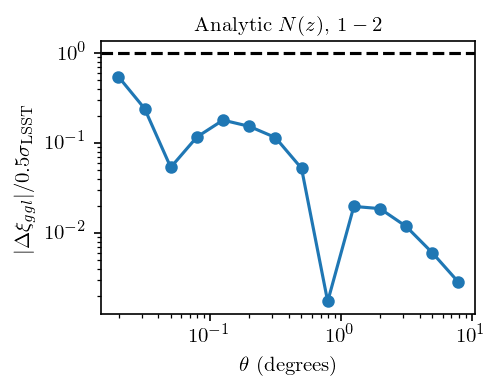

In [74]:
accuracy = 1

for nztyp in ['analytic'] :
    plt.figure(figsize=fig_size)
    plt.plot(theta_deg[1:],np.abs(corr_bench[nztyp]['xi'][1:]-corr_fftlog[nztyp][1:])/(0.5*sig_wt_spline(theta_deg[1:])),"o-",c=color_map(0), ms=5,label='FFTLog')
    #plt.plot(theta_deg[1:],np.abs(corr_bench[nztyp]['xi'][1:]-corr_bessel[nztyp][1:])/(0.5*sig_wt_spline(theta_deg[1:])),"o-",c=color_map(1), ms=5,label='Brute-force')
    plt.xscale('log')
    plt.yscale('log')
    plt.axhline(accuracy, c="k", ls="--")
    plt.xlabel(r'$\theta$ (degrees)')
    plt.ylabel(r'$|\Delta \xi_{ggl}|/0.5\sigma_{\rm LSST}$')
    plt.title(r'Analytic $N(z)$, $1-2$')
    plt.gcf().subplots_adjust(**plot_adjust)
    plt.savefig('projected_xiggl_error_comparison_'+nztyp+'.pdf')
    plt.show()
    plt.clf()

# Matter power spectrum

CCL uses different methods to predict the matter power spectrum. In this section, we establish the accuracy with which they are implemented.

### Cosmological Emulator - case with no neutrinos

The Cosmic Emulator is one of the methods used for the matter power spectrum predictions (Lawrence et al., 2017, arXiv:1705.03388). We first load the emulator cosmologies. Among them, we will only use models: 1,3,5,6,8,10. We will compare to CCL at z=0. The requirement is a fracional discrepancy lower than 3%. This is the tolerance we have required based on the emulator paper results (Section 3.3, Fig 6). 

In [ ]:
#Load benchmark cosmology
emu_cosmo_mat=np.loadtxt('../tests/benchmark/emu_cosmologies.txt')
Omega_c_emu=emu_cosmo_mat[:,0]
Omega_b_emu=emu_cosmo_mat[:,1]
h_emu=emu_cosmo_mat[:,2]
sigma8_emu=emu_cosmo_mat[:,3]
ns_emu=emu_cosmo_mat[:,4]
w0_emu=emu_cosmo_mat[:,5]
wa_emu=emu_cosmo_mat[:,6]
models = np.array([1,3,5,6,8,10])
colvec=plt.cm.magma(np.linspace(0,0.8,len(models)))

#Compare CCL to the same simulated power spectra that CosmicEmu was compared against. 
accuracy = 1e-2

plt.figure(figsize=fig_size)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gcf().subplots_adjust(**plot_adjust)
plt.gca().set_xscale('log')
for i_model in range(0,len(models)):
    cosmo_emu = ccl.Cosmology(
        Omega_c=Omega_c_emu[i_model], Omega_b=Omega_b_emu[i_model], h=h_emu[i_model], 
        sigma8=sigma8_emu[i_model], n_s=ns_emu[i_model], w0=w0_emu[i_model], 
        wa=wa_emu[i_model], Neff=3.04,
        transfer_function='emulator',
        matter_power_spectrum='emu', Omega_g=0.0)
    pk_emu=np.loadtxt("../tests/benchmark/emu_smooth_pk_M"+str(models[i_model])+".txt")
    pk_ccl=ccl.nonlin_matter_power(cosmo_emu,pk_emu[:,0],1.)
    plt.plot(pk_emu[:,0],np.abs(pk_ccl/pk_emu[:,1]-1.),'-',color=color_map(i_model),
             label="M{}".format(models[i_model]))
    
plt.legend(ncol=3, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(0, 1.4e-2)
plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.axhline(accuracy, c="k", ls="--")
plt.savefig('poweremu.pdf')
plt.show()
plt.clf()

### Cosmological Emulator - with neutrinos

Similar to the case above, but for cosmologies with neutrinos.

In [ ]:
emu_cosmo_mat=np.loadtxt('../tests/benchmark/emu_nu_cosmologies.txt')
Omega_c_emu=emu_cosmo_mat[:,0]
Omega_b_emu=emu_cosmo_mat[:,1]
h_emu=emu_cosmo_mat[:,2]
sigma8_emu=emu_cosmo_mat[:,3]
ns_emu=emu_cosmo_mat[:,4]
w0_emu=emu_cosmo_mat[:,5]
wa_emu=emu_cosmo_mat[:,6]
Omega_nu_emu=emu_cosmo_mat[:,7]
models = np.array([38,39,40,42])
colvec=plt.cm.magma(np.linspace(0,0.8,len(models)))


accuracy = 3e-2

plt.figure(figsize=fig_size)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gcf().subplots_adjust(**plot_adjust)
plt.gca().set_xscale('log')
for i_model in range(0,len(models)):
    #Figure out the neutrino mass for this Omega_nu:
    Mnu_out = ccl.nu_masses(Omega_nu_emu[i_model]*h_emu[i_model]**2, 'equal', 2.725)
    cosmo_emu = ccl.Cosmology(
        Omega_c=Omega_c_emu[i_model], Omega_b=Omega_b_emu[i_model], h=h_emu[i_model], 
        sigma8=sigma8_emu[i_model], m_nu=Mnu_out, n_s=ns_emu[i_model], w0=w0_emu[i_model], 
        wa=wa_emu[i_model], Neff=3.04, transfer_function='emulator', matter_power_spectrum='emu',
        Omega_g=0.0)
    pk_emu=np.loadtxt("../tests/benchmark/emu_nu_smooth_pk_M"+str(models[i_model])+".txt")
    pk_ccl=ccl.nonlin_matter_power(cosmo_emu,pk_emu[:,0],1.)
    plt.plot(pk_emu[:,0],np.abs(pk_ccl/pk_emu[:,1]-1.),'-',color=color_map(i_model), 
             label="M{}".format(models[i_model]))
    
plt.legend(ncol=2, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(0, 4e-2)
plt.locator_params(axis="y", nbins=6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.axhline(accuracy, c="k", ls="--")

plt.savefig('poweremu_nu.pdf')
plt.show()
plt.clf()

### Baryonic correction model

To incorporate the effect of baryons on the matter power spectrum, CCL uses the BC model of Schenider & Teyssier (2015, arXiv:1510.06034). Here, we test that we have implemented this model correctly. 

Max diff for BCM= 8.452127886471317e-13


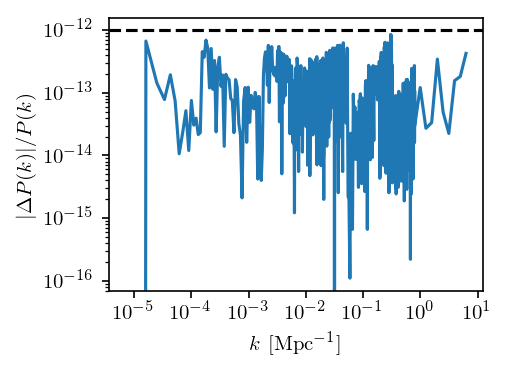

In [58]:
#Set-up two cosmologies, with and without baryons
cosmo_bar = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.2e-9, n_s=0.96, Neff=3.046,
    bcm_log10Mc=14., baryons_power_spectrum='bcm', Omega_g=0.0)

cosmo_nobar = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.2e-9, n_s=0.96,  Neff=3.046, Omega_g=0.0)

#Load two benchmark power spectra, with and without baryons
pk_bench_bar=np.loadtxt('../tests/benchmark/bcm/w_baryonspk_nl.dat')
pk_bench_nobar=np.loadtxt('../tests/benchmark/bcm/wo_baryonspk_nl.dat')

#Make the CCL prediction
pk_ccl_bar=ccl.nonlin_matter_power(cosmo_bar,pk_bench_bar[:,0]*0.7,1.)
pk_ccl_nobar=ccl.nonlin_matter_power(cosmo_nobar,pk_bench_bar[:,0]*0.7,1.)


#Ensure that the ratio of the two types of power spectra is within a certain tolerance.
accuracy = 1e-12

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gca().set_xscale('log')
plt.plot(pk_bench_bar[:,0]*0.7,np.abs(pk_ccl_bar/pk_ccl_nobar/(pk_bench_bar[:,1]/pk_bench_nobar[:,1])-1.),
         '-',color=color_map(0))
print("Max diff for BCM=",np.max(np.abs(pk_ccl_bar/pk_ccl_nobar/(pk_bench_bar[:,1]/pk_bench_nobar[:,1])-1.)))
plt.axhline(accuracy, c="k", ls="--")

plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.yscale("log")
plt.locator_params(axis="x", numticks=7)

plt.savefig('bcm.pdf')
plt.show()
plt.clf()

### Matter power spectrum via BBKS

This test compares the BBKS implementation of the matter power spectrum in CCL for three cosmologies and at z=0 and z=1. Other redshifts are available where the accuracy is 1E-5. 

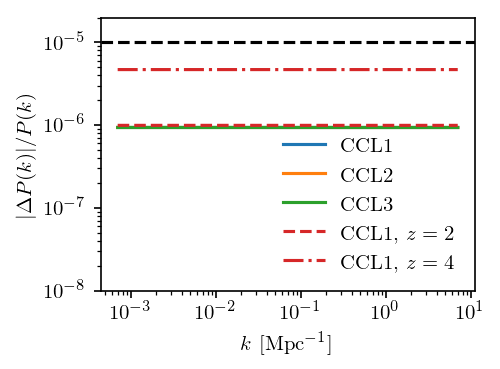

In [59]:
#BBKS cosmologies
cosmo_ccl1_bbks = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.96, Neff=0,
    transfer_function='bbks', matter_power_spectrum='linear', Omega_g=0.0)

cosmo_ccl2_bbks = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.96, w0=-0.9, Neff=0,
    transfer_function='bbks', matter_power_spectrum='linear', Omega_g=0.0)

cosmo_ccl3_bbks = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.96, w0=-0.9, wa=0.1, Neff=0,
    transfer_function='bbks', matter_power_spectrum='linear', Omega_g=0.0)

#Load three benchmark power spectra, with and without baryons
pk_bench_m1=np.loadtxt('../tests/benchmark/model1_pk.txt')
pk_bench_m2=np.loadtxt('../tests/benchmark/model2_pk.txt')
pk_bench_m3=np.loadtxt('../tests/benchmark/model3_pk.txt')

#Make the CCL prediction
pk_ccl1_bbks=ccl.linear_matter_power(cosmo_ccl1_bbks,pk_bench_m1[:,0]*0.7,1.)
pk_ccl1_bbks_z1=ccl.linear_matter_power(cosmo_ccl1_bbks,pk_bench_m1[:,0]*0.7,0.5)
pk_ccl1_bbks_z2=ccl.linear_matter_power(cosmo_ccl1_bbks,pk_bench_m1[:,0]*0.7,1./3.)
pk_ccl1_bbks_z3=ccl.linear_matter_power(cosmo_ccl1_bbks,pk_bench_m1[:,0]*0.7,0.25)
pk_ccl1_bbks_z4=ccl.linear_matter_power(cosmo_ccl1_bbks,pk_bench_m1[:,0]*0.7,0.2)
pk_ccl2_bbks=ccl.linear_matter_power(cosmo_ccl2_bbks,pk_bench_m2[:,0]*0.7,1.)
pk_ccl3_bbks=ccl.linear_matter_power(cosmo_ccl3_bbks,pk_bench_m3[:,0]*0.7,1.)


#Ensure that the ratio of the two types of power spectra is within a certain tolerance.
accuracy = 1e-5

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gca().set_xscale('log')
plt.ylim(bottom=1e-8,top=2e-5)
plt.plot(pk_bench_m1[:,0]*0.7,np.abs(pk_bench_m1[:,1]/0.7**3/pk_ccl1_bbks-1.),
         '-',color=color_map(0),label='CCL1')
plt.plot(pk_bench_m1[:,0]*0.7,np.abs(pk_bench_m2[:,1]/0.7**3/pk_ccl2_bbks-1.),
         '-',color=color_map(1),label='CCL2')
plt.plot(pk_bench_m1[:,0]*0.7,np.abs(pk_bench_m3[:,1]/0.7**3/pk_ccl3_bbks-1.),
         '-',color=color_map(2),label='CCL3')
plt.plot(pk_bench_m1[:,0]*0.7,np.abs(pk_bench_m1[:,3]/0.7**3/pk_ccl1_bbks_z2-1.),
         '--',color=color_map(3),label=r'CCL1, $z=2$')
plt.plot(pk_bench_m1[:,0]*0.7,np.abs(pk_bench_m1[:,5]/0.7**3/pk_ccl1_bbks_z4-1.),
         '-.',color=color_map(3),label=r'CCL1, $z=4$')
plt.axhline(accuracy, c="k", ls="--")

plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.yscale("log")
plt.locator_params(axis="x", numticks=7)
plt.legend(loc='lower right',fontsize=10,frameon=False)
plt.savefig('bbks.pdf')
plt.show()
plt.clf()

### Matter power spectrum via Eisenstein & Hu

This test compares the Eisenstein & Hu implementation of the matter power spectrum in CCL against an independent benchmark at z=0 and for the CCL1 cosmology.

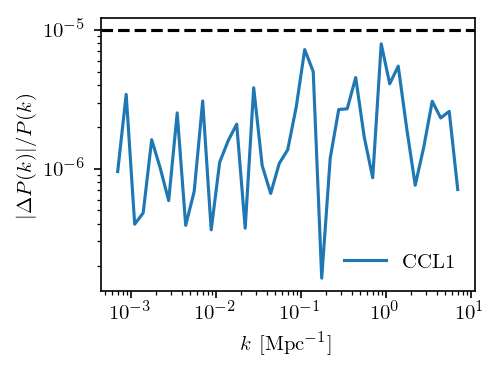

In [60]:
#BBKS cosmologies
cosmo_ccl1_eh= ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.96, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='linear')

#Load three benchmark power spectra, with and without baryons
pk_bench_m1=np.loadtxt('../tests/benchmark/model1_pk_eh.txt')
#Make the CCL prediction
pk_ccl1_eh=ccl.linear_matter_power(cosmo_ccl1_eh,pk_bench_m1[:,0]*0.7,1.)

#Ensure that the ratio of the two types of power spectra is within a certain tolerance.
accuracy = 1e-5

#Only z=0 results shown, up to z=5 available.
plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gca().set_xscale('log')
#plt.ylim(ymin=5e-8,ymax=2e-5)
plt.plot(pk_bench_m1[:,0]*0.7,np.abs(pk_bench_m1[:,1]/0.7**3/pk_ccl1_eh-1.),
         '-',color=color_map(0),label='CCL1')
plt.axhline(accuracy, c="k", ls="--")

plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.yscale("log")
plt.locator_params(axis="x", numticks=7)
plt.legend(loc='lower right',fontsize=10,frameon=False)
plt.savefig('ehu.pdf')
plt.show()
plt.clf()

### Matter power spectrum from CLASS with massive neutrinos

This test compares the matter power spectrum in cosmologies with massive neutrinos computed using CLASS and called using CCL to that computed via CLASS externally. This is simply intended to check that we are setting up massive neutrino parameters correctly and passing parameters correctly to CLASS, not to test the P(k) computation itself. The accuracy achieved for both linear and nonlinear power spectra is 1E-3.

First, set up the cosmologies we use here.

In [61]:
cosmo_cclmnu1_pk = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, 
    n_s=0.96, Neff=3.046, m_nu=[0.04, 0., 0.])
cosmo_cclmnu2_pk = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, 
    n_s=0.96, w0=-0.9, Neff=3.046, m_nu=[0.05, 0.01, 0.])
cosmo_cclmnu3_pk = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, A_s = 2.1e-9, 
    n_s=0.96, w0=-0.9, wa=0.1, Neff=3.046, m_nu=[0.03, 0.02, 0.04])

cosmo_mnu_pk_list = [cosmo_cclmnu1_pk, cosmo_cclmnu2_pk, cosmo_cclmnu3_pk]
num_models_mnu_pk = 3;

model_names = ["CCL7", "CCL8", "CCL9"]

Next, load the benchmarks for the linear and nonlinear matter power spectrum (computed using CLASS externally).

In [62]:
lin_k_pk = [np.loadtxt("../tests/benchmark/model"+str(mi+1)+"_pk_nu.txt", unpack=True) for mi in range(num_models_mnu_pk)]
nl_k_pk = [np.loadtxt("../tests/benchmark/model"+str(mi+1)+"_pk_nl_nu.txt", unpack=True) for mi in range(num_models_mnu_pk)]

#### Linear matter power spectrum with massive neutrinos

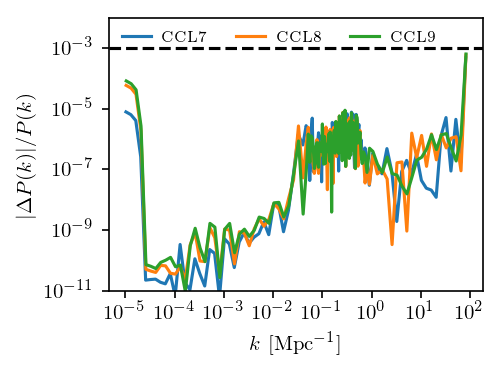

In [63]:
colvec=plt.cm.magma(np.linspace(0,0.8,num_models_mnu_pk))

accuracy = 1e-3

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gca().set_xscale('log')
for i_model in range(0,num_models_mnu_pk):
    pk_lin_ccl = ccl.linear_matter_power(
        cosmo_mnu_pk_list[i_model], 
        lin_k_pk[i_model][0] * cosmo_mnu_pk_list[i_model]['h'],1.) * (cosmo_mnu_pk_list[i_model]['h'])**3
    plt.plot(lin_k_pk[i_model][0],np.abs(pk_lin_ccl/lin_k_pk[i_model][1]-1.),
             ls='-', color=color_map(i_model), label=model_names[i_model])
    
plt.yscale("log")
plt.legend(ncol=3, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(1e-11, 1e-2)
# plt.locator_params(axis="y", nbins=6)
# plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.locator_params(axis="x", numticks=8)
plt.axhline(accuracy, c="k", ls="--")
plt.savefig('pk_class_nu.pdf')
plt.show()
plt.clf()

#### Nonlinear matter power spectrum with massive neutrinos

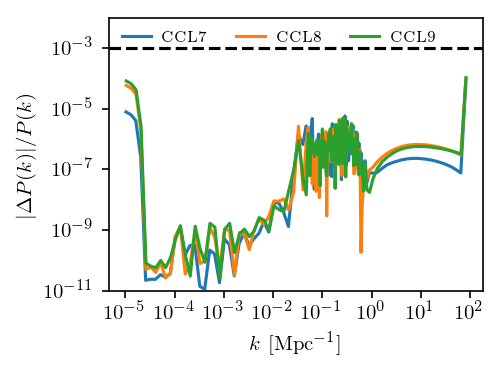

In [64]:
colvec=plt.cm.magma(np.linspace(0,0.8,num_models_mnu_pk))

accuracy = 1e-3

plt.figure(figsize=fig_size)
plt.ylabel(r'$|\Delta P(k)|/P(k)$')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.gcf().subplots_adjust(**plot_adjust)
plt.gca().set_xscale('log')
for i_model in range(0,num_models_mnu_pk):
    pk_nl_ccl=ccl.nonlin_matter_power(
        cosmo_mnu_pk_list[i_model],
        lin_k_pk[i_model][0] * cosmo_mnu_pk_list[i_model]['h'],1.) * (cosmo_mnu_pk_list[i_model]['h'])**3
    plt.plot(nl_k_pk[i_model][0],np.abs(pk_nl_ccl/nl_k_pk[i_model][1]-1.),
             ls='-', color=color_map(i_model), label=model_names[i_model])
    
plt.yscale("log")
plt.legend(ncol=3, loc="upper left", fontsize="x-small", frameon=False)
plt.ylim(1e-11, 1e-2)
# plt.locator_params(axis="y", nbins=6)
# plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.locator_params(axis="x", numticks=8)
plt.axhline(accuracy, c="k", ls="--")
plt.savefig('pk_class_nu_NL.pdf')
plt.show()
plt.clf()

The small and large wavenumber excess is produced by our extrapolation schemes for the power spectrum spines. 

## Mass function

This section of the notebook tests the halo mass function predictions in different forms.

In [65]:
#Load the benchmarks
bench=np.loadtxt('../tests/benchmark/model1_hmf.txt')
log10mass = bench[0:,0]
sigma = bench[0:,1]
log10invsigma = bench[0:,2]
log10massfunc = bench[0:,3]

scale_fact = 1.

# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.96,
    transfer_function='bbks', mass_function='tinker', Omega_g=0)

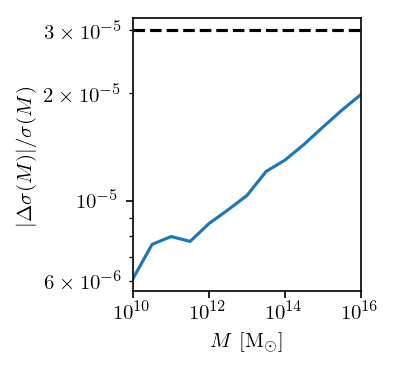

In [66]:
accuracy = 3e-5

mass_function_fig_size = (paper_textwidth/3, fig_size[1])
mass_function_plot_adjust = plot_adjust.copy()
mass_function_plot_adjust["left"] = 0.35
mass_function_plot_adjust["right"] = 0.99

#This plot shows the relative difference in sigmaM predictions.
plt.figure(figsize=mass_function_fig_size)
plt.gcf().subplots_adjust(**mass_function_plot_adjust)
plt.ylabel(r'$|\Delta \sigma(M)|/\sigma(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact)/sigma-1),
        c=color_map(0))
plt.axhline(accuracy, c="k", ls="--")
plt.yscale("log")
plt.locator_params(axis="x", numticks=4)
plt.xlim(left=1e10,right=1e16)
plt.savefig('hmf_model1.pdf')
plt.show()
plt.clf()

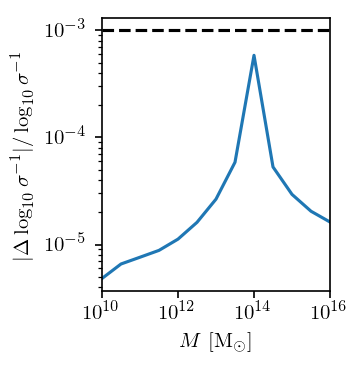

In [67]:
#This plot shows the accuracy in \log_{10}\sigma^{-1}
accuracy = 1e-3

plt.figure(figsize=mass_function_fig_size)
plt.gcf().subplots_adjust(**mass_function_plot_adjust)
plt.ylabel(r'$|\Delta \log_{10}\sigma^{-1}|/\log_{10}\sigma^{-1}$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(np.log10(1./ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact))/log10invsigma-1),
        c=color_map(0))
plt.axhline(accuracy, c="k", ls="--")
plt.yscale("log")
plt.xlim(left=1e10, right=1e16)
plt.locator_params(axis="x", numticks=4)

plt.savefig('hmf_model1_b.pdf')
plt.show()
plt.clf()

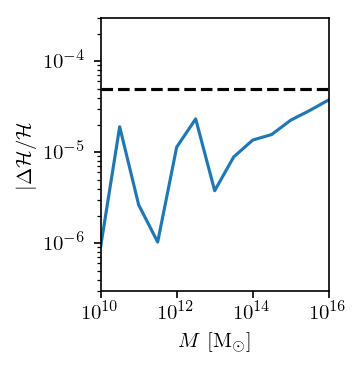

In [68]:
#This plot shows the accuracy in the actual mass function
rho_m = ccl.constants.RHO_CRITICAL*cosmo_ccl1_mf['Omega_m']*cosmo_ccl1_mf['h']**2
logmassfunc_test = np.log10(ccl.massfunc(cosmo_ccl1_mf, 10**log10mass, scale_fact)*(10**log10mass)/rho_m/np.log(10))

accuracy = 5e-5

plt.figure(figsize=mass_function_fig_size)
plt.gcf().subplots_adjust(**mass_function_plot_adjust)
plt.ylabel(r'$|\Delta\mathcal{H}/\mathcal{H}$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(logmassfunc_test/log10massfunc-1),
        c=color_map(0))
plt.axhline(accuracy, c="k", ls="--")
# plt.locator_params(axis="y", nbins=6)
# plt.ticklabel_format(style="sci", axis="y", scilimits=(0,1))
plt.yscale("log")

plt.ylim(bottom=3e-7, top=3e-4)
plt.xlim(left=1e10, right=1e16)
plt.locator_params(axis="x", numticks=4)

plt.savefig('hmf_model1_c.pdf')
plt.show()
plt.clf()

## 3d correlation

CCL can also make predictions for the three-dimensional correlation function. As a first test, we compare the CCL prediction to a benchmark output that yields a precise numerical transform of the halofit power spectrum as output from CCL.

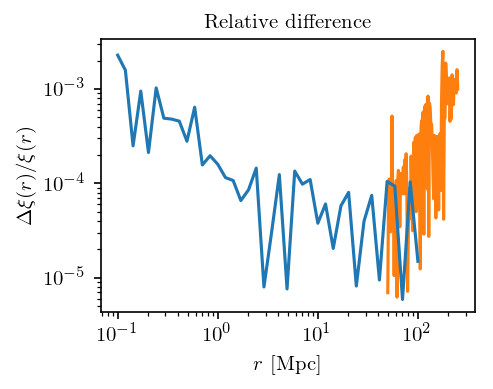

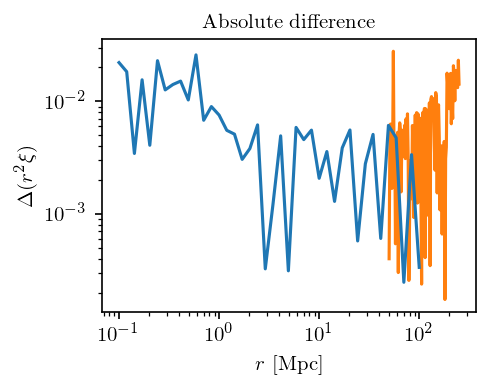

In [69]:
cosmo = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.80, n_s=0.96, w0=-1.0, wa=0.0, Omega_g=0)
# read in the benchmark xi values for each redshift z
bench = np.loadtxt('../tests/benchmark/model1_xi.txt')
d_bench = bench[0:,0:]

xi = []
for z in range(6): 
    xi.append(d_bench[0:,z+1])
xi_bench = np.asarray(xi)

# calculate CCL xi for r = 0.1 - 100 with 40 bins
nr1 = 40
r1 = np.logspace(-1, 2, nr1)
xi1 = []
for z in range(6):
    xi1.append(ccl.correlation_3d(cosmo, 1./(z+1), r1))

# calculate CCL xi for r = 50 - 250 with 100 bins to check agreement in the BAO peak region
nr2 = 100
r2 = np.logspace(np.log10(50), np.log10(250), nr2)
xi2 = []
for z in range(6):
    xi2.append(ccl.correlation_3d(cosmo, 1./(z+1), r2))

# Define redshift value and make plots
z = 0   

# Plot relative difference
frac_diff1 = []
frac_diff2 = []
abs_diff1 = []    
abs_diff2 = []

for i in range(nr1):
    frac_diff1.append(np.abs(xi1[z][i]/xi_bench[z][i] - 1.))
    abs_diff1.append(np.abs(r1[i]*r1[i]*(xi1[z][i]-xi_bench[z][i])))
    
for i in range(nr2):
    frac_diff2.append(np.abs(1-xi2[z][i]/xi_bench[z][i+40]))
    abs_diff2.append(np.abs(r2[i]*r2[i]*(xi2[z][i]-xi_bench[z][i+40])))


plt.figure(figsize=fig_size)
plt.plot(r2, frac_diff2, c=color_map(1))
plt.plot(r1, frac_diff1, c=color_map(0))
plt.xscale('log')
plt.yscale('log')
plt.gcf().subplots_adjust(**plot_adjust)
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$\Delta \xi(r) / \xi(r)$')
plt.title('Relative difference') 
plt.savefig('benchmark_xi_rel.pdf')
plt.show()
plt.clf()

# plot absolute difference in r^2 xi(r)
plt.figure(figsize=fig_size)
plt.plot(r2, abs_diff2, c=color_map(1))
plt.plot(r1, abs_diff1, c=color_map(0))
plt.xscale('log')
plt.yscale('log')
plt.gcf().subplots_adjust(**plot_adjust)
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$\Delta (r^2 \xi) $')
plt.title('Absolute difference')
plt.savefig('benchmark_xi_abs.pdf')
plt.show()
plt.clf()



### Compare CCL transform with known transform of an analytic function 

In this case, we compare the CCL prediction to two different analytical predictions. The blue curve is the case of 

\begin{equation}
\xi \propto r^{1.67},
\end{equation}
while the orange curve corresponds to a case where 
\begin{equation}
P(k) \sim Ak/(k+k_0), 
\end{equation}

which asymptotes to P(k) at low k as expected.

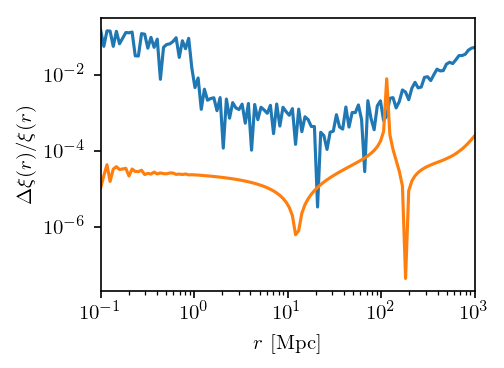

In [70]:
# read 3d correlation analytic benchmark test data and plot
bench_analytic = np.loadtxt('analytic_xi_1.txt')
r = bench_analytic[:,0]
diff = bench_analytic[:,1]

bench_analytic2 = np.loadtxt('analytic_xi_2.txt')
diff2 = bench_analytic2[:,1]

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1,1000.))
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$\Delta \xi(r)/\xi(r)$')
plt.plot(r, diff)
plt.plot(r, diff2)
plt.savefig('3dcorr_analytic.pdf')


## Power spectrum spline accuracy check

This section of the notebook compares the predicted CCL power spectrum with default spline parameters to a high-accuracy settings version. Note that in this case both results are taken as input, as any modification of the accuracy parameters requires changes in the .ini file.

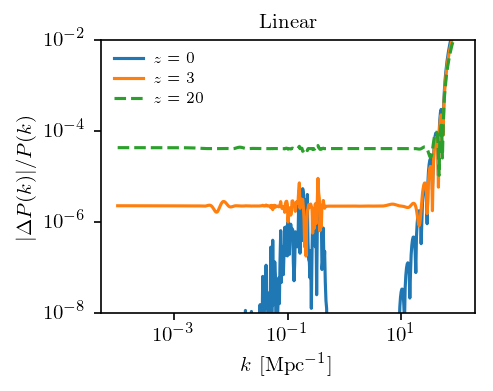

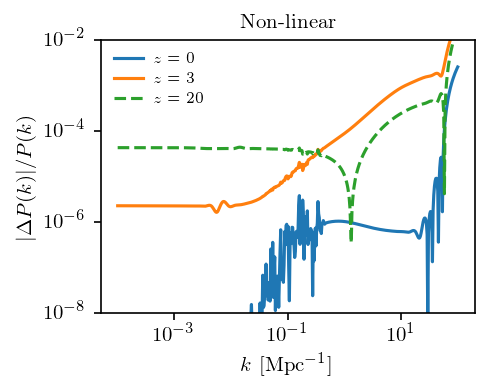

In [5]:
data_bm=np.load("pk_spline_bm.npz")

cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, A_s=2.1e-9, n_s=0.96)

k=data_bm['k']
pk_ln_0=ccl.linear_matter_power(cosmo,k,1./(1+data_bm['z0']))
pk_nl_0=ccl.nonlin_matter_power(cosmo,k,1./(1+data_bm['z0']))
pk_ln_1=ccl.linear_matter_power(cosmo,k,1./(1+data_bm['z1']))
pk_nl_1=ccl.nonlin_matter_power(cosmo,k,1./(1+data_bm['z1']))
pk_ln_2=ccl.linear_matter_power(cosmo,k,1./(1+data_bm['z2']))
pk_nl_2=ccl.nonlin_matter_power(cosmo,k,1./(1+data_bm['z2']))

delta_pk=abs(pk_ln_0/data_bm['pk_ln_0']-1)
delta_pk2=abs(pk_nl_0/data_bm['pk_nl_0']-1)
delta_pk_z3=abs(pk_ln_1/data_bm['pk_ln_1']-1)
delta_pk2_z3=abs(pk_nl_1/data_bm['pk_nl_1']-1)
delta_pk_z20=abs(pk_ln_2/data_bm['pk_ln_2']-1)
delta_pk2_z20=abs(pk_nl_2/data_bm['pk_nl_2']-1)

fig=plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)

ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_ylabel(r'$|\Delta P(k)|/P(k)$')

plt.plot(k,np.fabs(delta_pk),color=color_map(0),label='$z=0$')
plt.plot(k,np.fabs(delta_pk_z3),color=color_map(1),label='$z=3$')
plt.plot(k,np.fabs(delta_pk_z20),color=color_map(2),ls='--',label='$z=20$')
plt.legend(loc='upper left',frameon=False, fontsize="x-small")
ax.set_ylim([1E-8,1E-2])

ax.set_title("Linear")

plt.savefig("splacc_power_lin.pdf")



fig=plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)

ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax.set_ylabel(r'$|\Delta P(k)|/P(k)$')

plt.plot(k,np.fabs(delta_pk2),color=color_map(0),label='$z=0$')
plt.plot(k,np.fabs(delta_pk2_z3),color=color_map(1),label='$z=3$')
plt.plot(k,np.fabs(delta_pk2_z20),color=color_map(2),ls='--', label='$z=20$')
ax.set_ylim([1E-8,1E-2])
ax.set_title("Non-linear")
plt.legend(fontsize="x-small", frameon=False)

plt.savefig("splacc_power_nl.pdf")

## Generalized validation over LCDM parameter space

In general, we would like to repeat the same exercise as above for a wider range of cosmologies. This is the purpose of the next set of plots, which compare CCL predicted power spectra to CLASS outputs for many different cases.

z = 0.00


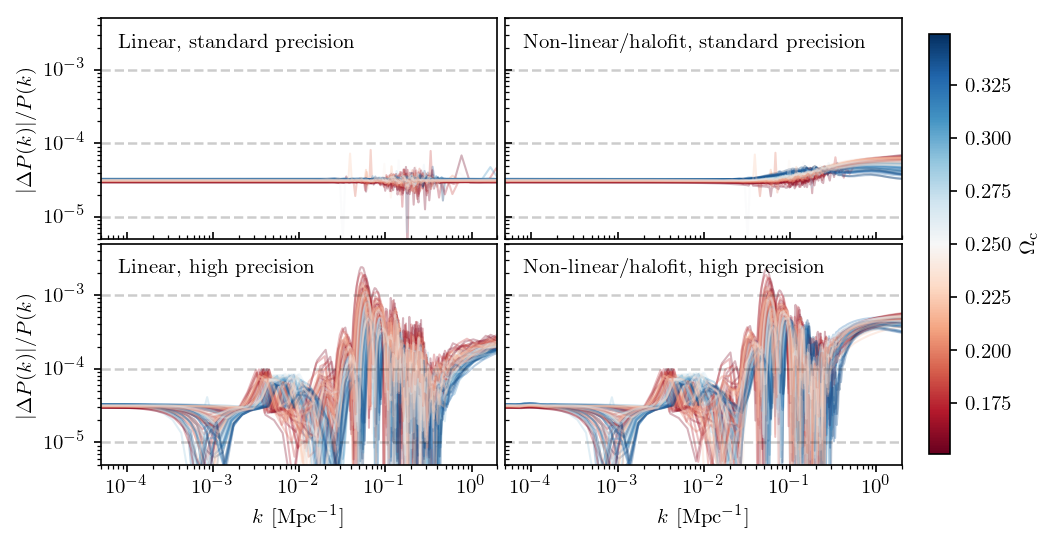

z = 2.00


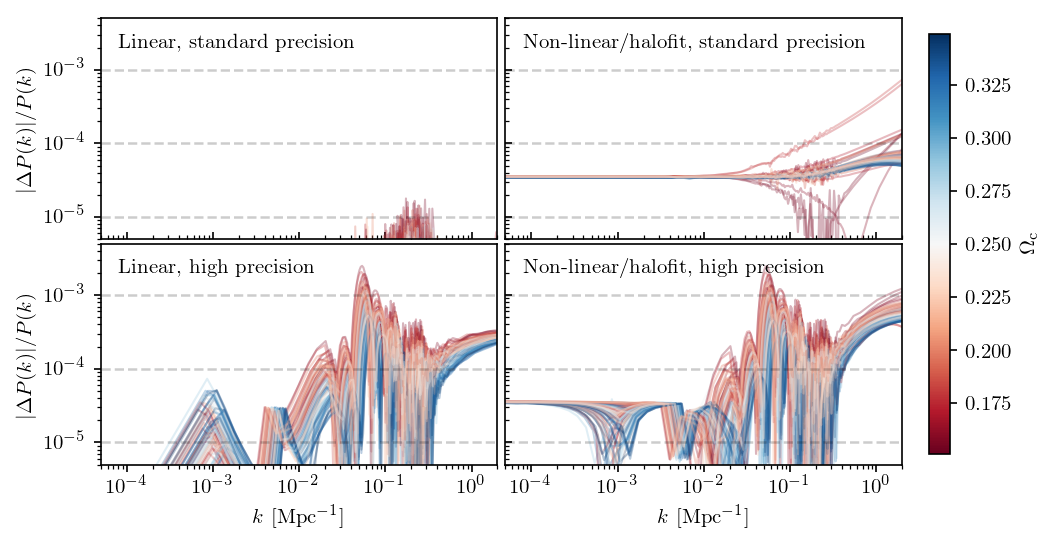

In [72]:
from matplotlib import gridspec

continuous_cmap = plt.get_cmap("RdBu")

# Define binning in (z, k) and threshold values
thresholds = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
scale_ranges = [(1e-4, 1e-2), (1e-2, 1e-1), (1e-1, 1e0)]
z_vals = np.arange(0., 3., 0.5)

# Calculate summary stats
# Shape: N_samples, N_thres, N_z, N_kbins
roots = ["%s_lin_std", "%s_nl_std", "%s_lin_pre", "%s_nl_pre"]
labels = ["Linear, standard precision", "Non-linear/halofit, standard precision", 
          "Linear, high precision", "Non-linear/halofit, high precision"]
frac_dev = []
k_arr = []

for j in range(len(roots)):
    _k_arr = np.load((roots[j]%"cache") + ".k_arr.npy", encoding="bytes")
    _frac_dev = np.load((roots[j]%"cache") + ".frac_dev.npy", encoding="bytes")
    frac_dev.append(_frac_dev)
    k_arr.append(_k_arr)



# Parameter values for each sample
x = np.loadtxt("std_params.dat", usecols=[2])

y = (x - np.min(x)) / (np.max(x) - np.min(x))

#Loop over redshifts
for z_idx in [0, 4]:
    # Set up grid of subplots
    gs1 = gridspec.GridSpec(2, 2)
    gs1.update(hspace=0.02, wspace=0.02, bottom=0.13, top=0.98, right=0.85, left=0.1)
    ax1 = plt.subplot(gs1[0, 0])
    ax2 = plt.subplot(gs1[0, 1])
    ax3 = plt.subplot(gs1[1, 0])
    ax4 = plt.subplot(gs1[1, 1])
    plt.gcf().set_size_inches((paper_textwidth, 3.5))

    # Loop over subplots
    for j, ax in enumerate([ax1, ax2, ax3, ax4]):
        for i in range(frac_dev[j].shape[0]):
            ax.plot(k_arr[j][i,z_idx], np.abs(frac_dev[j][i,z_idx]), alpha=0.3, 
                   color=continuous_cmap(y[i]), lw=1)

        # Hidden scatterplot
        sct = ax.scatter(-1.*np.ones(y.size), np.zeros(y.size), c=x, cmap=continuous_cmap)

        if j==2 or j==3: ax.set_xlabel(r"$k$ [Mpc$^{-1}$]")
        if j==0 or j==2: ax.set_ylabel(r"$|\Delta P(k)|/P(k)$")

        ax.axhline(1e-3, color='k', ls='dashed', lw=1.2, alpha=0.2)
        ax.axhline(1e-4, color='k', ls='dashed', lw=1.2, alpha=0.2)
        ax.axhline(1e-5, color='k', ls='dashed', lw=1.2, alpha=0.2)
        
        ax.tick_params(axis='both', which='major')
        ax.tick_params(axis='both', which='minor')

        if j==0 or j==1: 
            ax.tick_params(axis='x', which='both', direction='in', labelbottom=False)
        if j==1 or j==3: 
            ax.tick_params(axis='y', which='both', direction='in', labelleft=False)

        ax.set_xlim((5e-5, 2e0))
        ax.set_ylim((5e-6, 5e-3))

        ax.set_yscale('log')
        ax.set_xscale('log')

        # Label each panel
        ax.text(8e-5, 2.e-3, labels[j])

    ax_cbar = plt.gcf().add_axes([0.62, 0.15, 0.3, 0.8])
    cbar = plt.gcf().colorbar(mappable=sct, ax=ax_cbar)
    cbar.set_label(r"$\Omega_{\rm c}$", labelpad=5)
    ax_cbar.axis('off')

    print("z = %2.2f" % z_vals[z_idx])

    plt.savefig("pkdev_v2_z{}.pdf".format("{:.2f}".format(z_vals[z_idx]).replace(".", "_")))
    plt.show()
    plt.clf()


## Halo model plots

Finally, CCL is capable of predicting the matter power spectrum via the halo model. This section establishes the numerical accuracy of that prediction when compared to an independent benchmark.

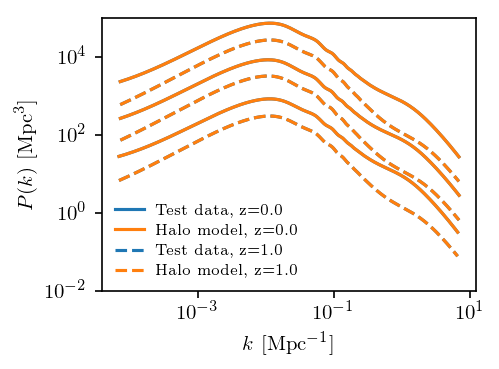

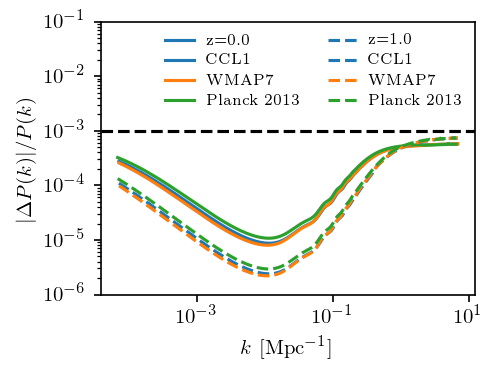

In [4]:
accuracy = 1e-3

# Number of cosmological models
nc=3

# Number of redshifts
z_list = [0., 1.]
nz = len(z_list)

# Number of points in k
nk = 256

# Declare arrays
k = np.zeros((nc, nk, nz))
Pk_in = np.zeros((nc, nk, nz))
Pk_hm = np.zeros((nc, nk, nz))

# Loop over redshifts
for j, z in enumerate(z_list):
    a = 1/(1+z)
        
    # Loop over cosmologies
    for i in range(nc):

        # Set the cosmological parameters and file locations
        if(i==0):
            infile="../tests/benchmark/pk_hm_c1_z%d.txt"%(int(z))
            Om_c=0.25
            Om_b=0.05
            h=0.7
            sig8=0.8
            n_s=0.96
        elif(i==1):
            infile="../tests/benchmark/pk_hm_c2_z%d.txt"%(int(z))
            Om_c=0.2265
            Om_b=0.0455
            h=0.7040
            sig8=0.8100
            n_s=0.9670
        elif(i==2):
            infile="../tests/benchmark/pk_hm_c3_z%d.txt"%(int(z))
            Om_c=0.2685
            Om_b=0.0490
            h=0.6711
            sig8=0.8340
            n_s=0.9624

        # Set the cosmology
        cosmo=ccl.Cosmology(Omega_c=Om_c, Omega_b=Om_b, h=h, sigma8=sig8, n_s=n_s,
                            transfer_function='eisenstein_hu',
                            matter_power_spectrum='halofit',
                            mass_function='shethtormen')

        # Load the data and pick out the k and P(k) columns
        data = np.loadtxt(infile)
        k[i,:,j] = data[:,0]
        Pk_in[i,:,j] = data[:,4]

        # Convert units of k from benchmark data [h/Mpc] -> [1/Mpc]
        k[i,:,j] = k[i,:,j]*h

        # Convert units of P(k) from benchmark data [Mpc/h]^3 -> [Mpc]^3
        Pk_in[i,:,j] = Pk_in[i,:,j]/h**3

        # Calculate the halo-model prediction
        Pk_hm[i,:,j] = ccl.halomodel_matter_power(cosmo, k[i,:,j], a)
        #Pk_hm[i,:,j]=ccl.onehalo_matter_power(cosmo, k[i,:,j], a)
        #Pk_hm[i,:,j]=ccl.linear_matter_power(cosmo, k[i,:,j], a)

# Plot the power spectra
plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$P(k)$ [Mpc$^3$]')
plt.ylim([1e-2,1e5])

# Loop over redshift and cosmological model
for j, z in enumerate(z_list):
    for i in range(nc):
        
        # Set the lables
        if(i==0):
            label_in='Test data, z={}'.format(z)
            label_hm='Halo model, z={}'.format(z)
        else:
            label_in=''
            label_hm=''
            
        # Set the line style
        if(j==0):
            ls_in='-'
            ls_hm='-'
        elif(j==1):
            ls_in='--'
            ls_hm='--'
            
        # Plot the data
        plt.plot(k[i,:,j], Pk_in[i,:,j]/10**i, ls=ls_in, c=color_map(0), label=label_in)
        plt.plot(k[i,:,j], Pk_hm[i,:,j]/10**i, ls=ls_hm, c=color_map(1), label=label_hm)
    
# Set the scale ranges
plt.legend(fontsize="x-small", frameon=False)


# Plot the residual
plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6, 1e-1)

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r"$|\Delta P(k)|/P(k)$")

cosmology_labels = ["CCL1", "WMAP7", "Planck 2013"]
# Loop over redshifts and cosmological model
for j, z in enumerate(z_list):
    # Set the labels
    if(j==0): ls='-'
    if(j==1): ls='--'
    plt.plot([], [], ls=ls, c=color_map(0), label="z={}".format(z))
    for i in range(nc):
        # Plot the data
        plt.plot(k[i,:,j], Pk_hm[i,:,j]/Pk_in[i,:,j]-1, ls=ls, c=color_map(i), label=cosmology_labels[i])
        
# Show the plot
plt.legend(fontsize="x-small", frameon=False, ncol=2)
plt.axhline(accuracy, c="k", ls="--")

plt.savefig("halo_model_benchmark.pdf")

The following plot illustrates the different components of the halo model.

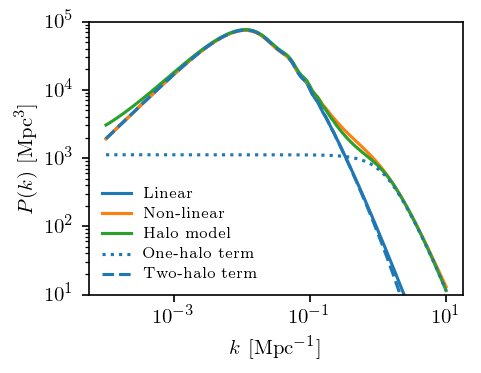

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96, Neff=3.04,
                      transfer_function='class',
                      matter_power_spectrum='halofit',
                      mass_function='shethtormen',
                      halo_concentration='duffy2008'
                     )

# Wavenumber
kmin=1e-4
kmax=1e1
nk=128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) 

# Scale factor
a = 1. 

# Calculate all these different P(k)
pk_li = ccl.linear_matter_power(cosmo, k, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)
pk_hm = ccl.halomodel_matter_power(cosmo, k, a)
pk_1h = ccl.halomodel.onehalo_matter_power(cosmo, k, a)
pk_2h = ccl.halomodel.twohalo_matter_power(cosmo, k, a)

plt.figure(figsize=fig_size)
plt.gcf().subplots_adjust(**plot_adjust)

plt.plot(k, pk_li, c=color_map(0),  label='Linear')
plt.plot(k, pk_nl, c=color_map(1),  label='Non-linear')
plt.plot(k, pk_hm, c=color_map(2),  label='Halo model')
plt.plot(k, pk_1h, c=color_map(0), ls=":",  label='One-halo term')
plt.plot(k, pk_2h, c=color_map(0), ls="--", label='Two-halo term')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$P(k)$ [Mpc$^3$]')
plt.ylim([1e1,1e5])
plt.legend(fontsize="x-small", frameon=False)
plt.savefig("halomodel.pdf")